In [2]:
import copy
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from boostedhh import utils, hh_vars, plotting
from boostedhh.utils import PAD_VAL
from bbtautau import bbtautau_vars

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger("boostedhh.utils")
logger.setLevel(logging.DEBUG)

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = Path("../../../")
CHANNEL = "muon"  # options: "hadronic", "electron", "muon"

plot_dir = MAIN_DIR / f"plots/SensitivityStudy/25Mar7{CHANNEL}"
plot_dir.mkdir(parents=True, exist_ok=True)

years = ["2023", "2023BPix"]  # "2022","2022EE",

tags = {
    "data": {
        "2022": "24Nov21ParTMass_v12_private_signal",
        "2022EE": "25Jan22AddYears_v12_private_signal",
        "2023": "25Mar7Signal_v12_private_signal",
        "2023BPix": "25Mar7Signal_v12_private_signal",
    },
    "signal": {
        "2022": "24Nov21ParTMass_v12_private_signal",
        "2022EE": "25Jan22AddYears_v12_private_signal",
        "2023": "25Mar7Signal_v12_private_signal",
        "2023BPix": "25Mar7Signal_v12_private_signal",
    },
}

base_dir = {
    "2022": Path("/ceph/cms/store/user/rkansal/bbtautau/skimmer/"),
    "2022EE": Path("/ceph/cms/store/user/rkansal/bbtautau/skimmer/"),
    "2023": Path("/ceph/cms/store/user/lumori/bbtautau/skimmer/"),
    "2023BPix": Path("/ceph/cms/store/user/lumori/bbtautau/skimmer/"),
}

In [5]:
qcdouts = ["QCD0HF", "QCD1HF", "QCD2HF"]
topouts = ["TopW", "TopbW", "TopbWev", "TopbWmv", "TopbWtauhv", "TopbWq", "TopbWqq"]
sigouts = ["Xtauhtauh", "Xtauhtaue", "Xtauhtaum", "Xbb"]

columns_data = {
    year: [
        ("weight", 1),
        ("ak8FatJetMsd", 3),
        ("ak8FatJetEta", 3),
        ("ak8FatJetPt", 3),
        ("ak8FatJetPhi", 3),
        ("ak8FatJetPNetXbbLegacy", 3),
        ("ak8FatJetPNetQCDLegacy", 3),
        ("ak8FatJetPNetmassLegacy", 3),
        ("ak8FatJetParTmassResApplied", 3),
        ("ak8FatJetParTmassVisApplied", 3),
    ]
    for year in years
}


columns_signal = copy.deepcopy(columns_data)

for year in years:
    for branch in (
        bbtautau_vars.HLT_hmu[year]
        + bbtautau_vars.HLT_he[year]
        + bbtautau_vars.HLT_dict[year]["PNet"]
        + bbtautau_vars.HLT_dict[year]["PFJet"]
        + bbtautau_vars.HLT_taus[year]
    ):
        columns_data[year].append((branch, 1))
        columns_signal[year].append((branch, 1))

    for branch in [f"ak8FatJetParT{key}" for key in qcdouts + topouts + sigouts]:
        columns_data[year].append((branch, 3))
        columns_signal[year].append((branch, 3))

    columns_signal[year] += [
        ("GenTauhh", 1),
        ("GenTauhmu", 1),
        ("GenTauhe", 1),
        ("GenHiggsEta", 2),
        ("GenHiggsPt", 2),
        ("GenHiggsPhi", 2),
        ("GenHiggsMass", 2),
        ("GenbbEta", 2),
        ("GenbbPt", 2),
        ("GenbbPhi", 2),
        ("GenbbMass", 2),
        ("GenTauEta", 2),
        ("GenTauPt", 2),
        ("GenTauPhi", 2),
        ("GenTauMass", 2),
        ("single_weight_genweight", 1),
        ("single_weight_pileup", 1),
        ("single_weight_ISRPartonShower", 1),
        ("single_weight_FSRPartonShower", 1),
    ]

## Define and load samples

In [6]:
# define samples to load
samples = {
    year: {
        "jetmet": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="JetHT|JetMET",
            label="JetMET",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "tau": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="Tau_Run",
            label="Tau",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "muon": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="Muon_Run",
            label="Muon",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "egamma": utils.Sample(
            path=base_dir[year] / tags["data"][year],
            selector="EGamma_Run",
            label="EGamma",
            isData=True,
            year=year,
            load_columns=utils.format_columns(columns_data[year]),
        ),
        "bbtt": utils.Sample(
            path=base_dir[year] / tags["signal"][year],
            selector=hh_vars.bbtt_sigs["bbtt"][year],
            label=r"HHbb$\tau\tau$",
            isData=False,
            year=year,
            load_columns=utils.format_columns(columns_signal[year]),
        ),
    }
    for year in years
}

# pick signal key based on channel
SIG_KEYS = {"hadronic": "bbtthh", "electron": "bbtthe", "muon": "bbtthmu"}
SIG_KEY = SIG_KEYS[CHANNEL]

# pick relevant data samples based on channel
DATA_KEYS = {
    "hadronic": ["jetmet", "tau"],
    "electron": ["jetmet", "tau", "egamma"],
    "muon": ["jetmet", "tau", "muon"],
}[CHANNEL]

# pick relevant lepton dataset based on channel
LEPTON_DATASET = {"hadronic": None, "electron": "egamma", "muon": "muon"}[CHANNEL]

LEPTON_TRIGGERS = {
    "hadronic": None,
    "electron": bbtautau_vars.HLT_he[years[0]],
    "muon": bbtautau_vars.HLT_hmu[years[0]],
}[CHANNEL]

for key in ["jetmet", "tau", "egamma", "muon"]:
    if key not in DATA_KEYS:
        for year in years:
            del samples[year][key]

In [ ]:
# pt_cut = 250
# msd_cut = 40

filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 250),
        ("('ak8FatJetPNetmassLegacy', '0')", ">=", 50),
        ("('ak8FatJetPt', '1')", ">=", 200),
        # ("('ak8FatJetMsd', '0')", ">=", msd_cut),
        # ("('ak8FatJetMsd', '1')", ">=", msd_cut),
        # ("('ak8FatJetPNetXbb', '0')", ">=", 0.8),
    ],
]


# dictionary that will contain all information (from all samples)
events_dict = {year: {} for year in years}

for year in years:
    for key, sample in samples[year].items():
        events_dict[year][key] = utils.load_sample(sample, filters)

    events_dict[year]["bbtthh"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhh"][0]
    ]
    events_dict[year]["bbtthmu"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhmu"][0]
    ]
    events_dict[year]["bbtthe"] = events_dict[year]["bbtt"][
        events_dict[year]["bbtt"]["GenTauhe"][0]
    ]
    del events_dict[year]["bbtt"]


cutflow = {year: pd.DataFrame(index=list(events_dict[year].keys())) for year in years}

for year in years:
    utils.add_to_cutflow(events_dict[year], "Preselection", "finalWeight", cutflow[year])

2025-03-31 17:40:09,875 - INFO - Loading ['JetMET_Run2023C_0v2', 'JetMET_Run2023C_0v1', 'JetMET_Run2023C_0v3', 'JetMET_Run2023C_1v1', 'JetMET_Run2023C_1v2', 'JetMET_Run2023C_0v4', 'JetMET_Run2023C_1v4']
2025-03-31 17:40:09,877 - DEBUG - Loading JetMET_Run2023C_0v2


2025-03-31 17:40:22,414 - INFO - Loaded JetMET_Run2023C_0v2                               : 2093674 entries
2025-03-31 17:40:22,417 - DEBUG - Loading JetMET_Run2023C_0v1
2025-03-31 17:40:44,513 - INFO - Loaded JetMET_Run2023C_0v1                               : 6940847 entries
2025-03-31 17:40:44,515 - DEBUG - Loading JetMET_Run2023C_0v3
2025-03-31 17:40:51,390 - INFO - Loaded JetMET_Run2023C_0v3                               : 2131021 entries
2025-03-31 17:40:51,392 - DEBUG - Loading JetMET_Run2023C_1v1
2025-03-31 17:41:07,275 - INFO - Loaded JetMET_Run2023C_1v1                               : 5050681 entries
2025-03-31 17:41:07,277 - DEBUG - Loading JetMET_Run2023C_1v2
2025-03-31 17:41:08,283 - INFO - Loaded JetMET_Run2023C_1v2                               : 406616 entries
2025-03-31 17:41:08,285 - DEBUG - Loading JetMET_Run2023C_0v4
2025-03-31 17:41:21,323 - INFO - Loaded JetMET_Run2023C_0v4                               : 3773871 entries
2025-03-31 17:41:21,338 - DEBUG - Loading J

## Triggers

In [ ]:
for year in years:
    for skey in SIG_KEYS.values():
        triggered = np.sum(
            [
                events_dict[year][skey][hlt].iloc[:, 0]
                for hlt in bbtautau_vars.HLT_map[CHANNEL][year]
            ],
            axis=0,
        ).astype(
            bool
        )  # Need to check
        events_dict[year][skey] = events_dict[year][skey][triggered]

### Data (overlap removal)

In [ ]:
trigdict = {year: {"jetmet": {}, "tau": {}} for year in years}

if LEPTON_DATASET:
    for year in years:
        trigdict[year][LEPTON_DATASET] = {}

for year in years:
    for key, d in trigdict[year].items():
        d["all"] = np.sum(
            [events_dict[year][key][hlt].iloc[:, 0] for hlt in bbtautau_vars.HLT_hmu[year]], axis=0
        ).astype(bool)
        d["jets"] = np.sum(
            [
                events_dict[year][key][hlt].iloc[:, 0]
                for hlt in bbtautau_vars.HLT_dict[year]["PNet"]
                + bbtautau_vars.HLT_dict[year]["PFJet"]
            ],
            axis=0,
        ).astype(bool)
        d["taus"] = np.sum(
            [events_dict[year][key][hlt].iloc[:, 0] for hlt in bbtautau_vars.HLT_taus[year]], axis=0
        ).astype(bool)

        d["taunojets"] = ~d["jets"] & d["taus"]

        if LEPTON_DATASET:
            d[LEPTON_DATASET] = np.sum(
                [events_dict[year][key][hlt].iloc[:, 0] for hlt in LEPTON_TRIGGERS], axis=0
            ).astype(bool)

            d[f"{LEPTON_DATASET}noothers"] = ~d["jets"] & ~d["taus"] & d[LEPTON_DATASET]

Checking event loss by flipping triggers (can skip)

In [ ]:
# xor = np.setdiff1d(
#     events_dict["jetmet"][trigdict["jetmet"]["nojettau"]]["event"][0],
#     events_dict["tau"][trigdict["tau"]["nojettau"]]["event"][0],
# )

# print(len(xor) / len(events_dict["jetmet"]))

# xor = np.setdiff1d(
#     events_dict["tau"][trigdict["tau"]["jetnotau"]]["event"][0],
#     events_dict["jetmet"][trigdict["jetmet"]["jets"]]["event"][0],
# )

# print(len(xor) / len(events_dict["tau"]))

Apply overlap removal

In [ ]:
for year in years:
    events_dict[year]["jetmet"] = events_dict[year]["jetmet"][trigdict[year]["jetmet"]["jets"]]
    events_dict[year]["tau"] = events_dict[year]["tau"][trigdict[year]["tau"]["taunojets"]]
    if LEPTON_DATASET:
        events_dict[year][LEPTON_DATASET] = events_dict[year][LEPTON_DATASET][
            trigdict[year][LEPTON_DATASET][f"{LEPTON_DATASET}noothers"]
        ]

In [ ]:
for year in years:
    utils.add_to_cutflow(events_dict[year], "Triggers", "finalWeight", cutflow[year])
cutflow

{'2023':          Preselection      Triggers
 jetmet   3.080492e+07  1.513714e+07
 tau      2.477410e+06  1.249548e+06
 muon     2.605226e+06  4.844000e+05
 bbtthh   5.384445e-01  4.796940e-01
 bbtthmu  2.234062e-01  2.061439e-01
 bbtthe   2.347330e-01  2.057004e-01,
 '2023BPix':          Preselection      Triggers
 jetmet   1.286855e+07  6.062770e+06
 tau      1.312411e+06  7.647510e+05
 muon     1.502305e+06  3.295270e+05
 bbtthh   2.910912e-01  2.592039e-01
 bbtthmu  1.165935e-01  1.066078e-01
 bbtthe   1.268147e-01  1.113407e-01}

## FatJet Gen Matching

In [ ]:
# merge years in gen matching
events = pd.concat([events_dict[year][SIG_KEY] for year in years], keys=[year for year in years])

higgs = utils.make_vector(events, "GenHiggs")
bb = utils.make_vector(events, "Genbb")
tt = utils.make_vector(events, "GenTau")
fatjets = utils.make_vector(events, "ak8FatJet", mstring="Msd")

events

KeyError: 'Could not find GenHiggsPt in events'

In [ ]:
minbb = np.min(higgs[:, 0:1].deltaR(bb), axis=1)
mintau = np.min(higgs[:, 0:1].deltaR(tt), axis=1)
genhbb1 = minbb < mintau

# minbb = np.min(higgs[:, 1:2].deltaR(bb), axis=1)
# mintau = np.min(higgs[:, 1:2].deltaR(tt), axis=1)
# genhbb2 = minbb < mintau  # overlap with genhb1 < 0.5% of the time

genhbb_mask = np.vstack([genhbb1, ~genhbb1]).T
genhbb = higgs[genhbb_mask]
genhtt = higgs[~genhbb_mask]

In [ ]:
fjbbdr = fatjets.deltaR(genhbb[:, np.newaxis])
fjidbb = np.argmin(fjbbdr, axis=1)
fjttdr = fatjets.deltaR(genhtt[:, np.newaxis])
fjidtt = np.argmin(fjttdr, axis=1)
# 5% of events have overlap out of which only 5% actually have two jets both close to a gen Higgs,
# so ignoring these overlap events for now
overlap = fjidbb == fjidtt

In [ ]:
np.mean(overlap)

0.06977877399863561

## Taggers

In [ ]:
taggers_dict = {year: {} for year in years}

taukey = {"hadronic": "Xtauhtauh", "electron": "Xtauhtaue", "muon": "Xtauhtaum"}[CHANNEL]

for year in years:
    for key, events in events_dict[year].items():
        tvars = {}

        qcdouts = ["QCD0HF", "QCD1HF", "QCD2HF"]  # HF = heavy flavor = {c,b}
        topouts = ["TopW", "TopbW"]  # "TopbWev", "TopbWmv", "TopbWtauhv", "TopbWq", "TopbWqq"]
        tvars["PQCD"] = sum([events[f"ak8FatJetParT{k}"] for k in qcdouts]).to_numpy()
        tvars["PTop"] = sum([events[f"ak8FatJetParT{k}"] for k in topouts]).to_numpy()

        for disc in ["Xbb", taukey]:
            tvars[f"{disc}vsQCD"] = np.nan_to_num(
                events[f"ak8FatJetParT{disc}"] / (events[f"ak8FatJetParT{disc}"] + tvars["PQCD"]),
                nan=PAD_VAL,
            )
            tvars[f"{disc}vsQCDTop"] = np.nan_to_num(
                events[f"ak8FatJetParT{disc}"]
                / (events[f"ak8FatJetParT{disc}"] + tvars["PQCD"] + tvars["PTop"]),
                nan=PAD_VAL,
            )

            # make sure not to choose padded jets below by accident
            nojet3 = events["ak8FatJetPt"][2] == PAD_VAL
            tvars[f"{disc}vsQCD"][:, 2][nojet3] = PAD_VAL
            tvars[f"{disc}vsQCDTop"][:, 2][nojet3] = PAD_VAL

        tvars["PNetXbbvsQCD"] = np.nan_to_num(
            events["ak8FatJetPNetXbbLegacy"]
            / (events["ak8FatJetPNetXbbLegacy"] + events["ak8FatJetPNetQCDLegacy"]),
            nan=PAD_VAL,
        )

        # jet assignment
        fjbbpick = np.argmax(tvars["XbbvsQCD"], axis=1)
        fjttpick = np.argmax(tvars[f"{taukey}vsQCD"], axis=1)
        overlap = fjbbpick == fjttpick
        fjbbpick[overlap] = np.argsort(tvars["XbbvsQCD"][overlap], axis=1)[:, -2]

        # convert ids to boolean masks
        fjbbpick_mask = np.zeros_like(tvars["XbbvsQCD"], dtype=bool)
        fjbbpick_mask[np.arange(len(fjbbpick)), fjbbpick] = True
        fjttpick_mask = np.zeros_like(tvars[f"{taukey}vsQCD"], dtype=bool)
        fjttpick_mask[np.arange(len(fjttpick)), fjttpick] = True

        tvars["bb_mask"] = fjbbpick_mask
        tvars["tautau_mask"] = fjttpick_mask
        taggers_dict[year][key] = tvars

Checking bb matching accuracy (can skip)

In [ ]:
tvars = {}
if len(years) > 1:
    for key in taggers_dict[years[0]][SIG_KEY].keys():
        tvars[key] = np.concatenate([taggers_dict[year][SIG_KEY][key] for year in years])
else:
    tvars = taggers_dict[years[0]][SIG_KEY]

maxtxbb = np.max(tvars["XbbvsQCD"], axis=1)
fjbbpick = np.argmax(tvars["XbbvsQCD"], axis=1)
maxtxtt = np.max(tvars[f"{taukey}vsQCD"], axis=1)
fjttpick = np.argmax(tvars[f"{taukey}vsQCD"], axis=1)

# how many are assigned correctly?
print(f"Correct matching bb: {np.mean(fjbbpick == fjidbb)}")
print(f"Correct matching tt: {np.mean(fjttpick == fjidtt)}")

overlap = fjbbpick == fjttpick
print(f"Overlap: {np.mean(overlap)}")
# how many pass reasonable tagger cuts?
print(
    f"How many overlaps pass basic tagger cuts: {np.sum((maxtxbb > 0.8) * (maxtxtt > 0.95) * overlap) / np.sum(overlap)}"
)  # <0.1%

NameError: name 'fjidbb' is not defined

In [ ]:
def get_jet_vals(vals, mask):
    # check if vals is a numpy array
    if not isinstance(vals, np.ndarray):
        vals = vals.to_numpy()

    return vals[mask]

In [ ]:
print(taggers_dict[years[0]])
for key in taggers_dict[years[0]]:
    print("1 \n\n\n")
    print([taggers_dict[year][key] for year in years])
    # np.concatenate([taggers_dict[year][key] for year in years])
# taggers_dict_merged  = {key: np.concatenate([taggers_dict[year][key] for year in years]) for key in taggers_dict[years[0]]}

{'jetmet': {'PQCD': array([[ 8.31207275e-01,  9.50057983e-01, -2.99997000e+05],
       [ 1.61708593e-02,  5.76938629e-01, -2.99997000e+05],
       [ 6.54235840e-01,  4.01016235e-01, -2.99997000e+05],
       ...,
       [ 6.50019646e-02,  5.72540283e-01,  2.88955688e-01],
       [ 3.69201489e-02,  4.99401093e-02, -2.99997000e+05],
       [ 1.00692749e-01,  8.70452881e-01, -2.99997000e+05]]), 'PTop': array([[ 2.27355957e-03,  2.99348831e-02, -1.99998000e+05],
       [ 2.39777565e-03,  5.13839722e-03, -1.99998000e+05],
       [ 6.40411377e-02,  1.15287781e-01, -1.99998000e+05],
       ...,
       [ 4.81307507e-03,  7.38830566e-02,  1.80412292e-01],
       [ 6.80276394e-01,  1.62086487e-01, -1.99998000e+05],
       [ 1.42700195e-01,  2.07595825e-02, -1.99998000e+05]]), 'XbbvsQCD': array([[ 1.18663520e-04,  2.36967627e-04, -9.99990000e+04],
       [ 2.85762066e-03,  4.31543847e-03, -9.99990000e+04],
       [ 5.45681232e-03,  1.23747972e-03, -9.99990000e+04],
       ...,
       [ 4.89980135e

### ROC Curves

In [ ]:
from sklearn.metrics import roc_curve


def compute_rocs(
    years,
    jets=["bb", "tautau"],
    discs=["XbbvsQCD", "XbbvsQCDTop", f"{taukey}vsQCD", f"{taukey}vsQCDTop", "PNetXbbvsQCD"],
):

    rocs = {}

    for jet in jets:
        print(jet)
        rocs[jet] = {}
        for i, disc in enumerate(discs):
            print("\t" + disc)

            bg_scores = np.concatenate(
                [
                    get_jet_vals(
                        taggers_dict[year][key][disc], taggers_dict[year][key][f"{jet}_mask"]
                    )
                    for key in DATA_KEYS
                    for year in years
                ]
            )
            bg_weights = np.concatenate(
                [events_dict[year][key]["finalWeight"] for key in DATA_KEYS for year in years]
            )

            sig_scores = np.concatenate(
                [
                    get_jet_vals(
                        taggers_dict[year][SIG_KEY][disc],
                        taggers_dict[year][SIG_KEY][f"{jet}_mask"],
                    )
                    for year in years
                ]
            )
            sig_weights = np.concatenate(
                [events_dict[year][SIG_KEY]["finalWeight"] for year in years]
            )

            fpr, tpr, thresholds = roc_curve(
                np.concatenate([np.zeros_like(bg_scores), np.ones_like(sig_scores)]),
                np.concatenate([bg_scores, sig_scores]),
                sample_weight=np.concatenate([bg_weights, sig_weights]),
            )

            rocs[jet][disc] = {
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                "label": disc,
                "color": plt.cm.tab10.colors[i],
            }

    return rocs

In [ ]:
rocs_full = compute_rocs(years)

bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD


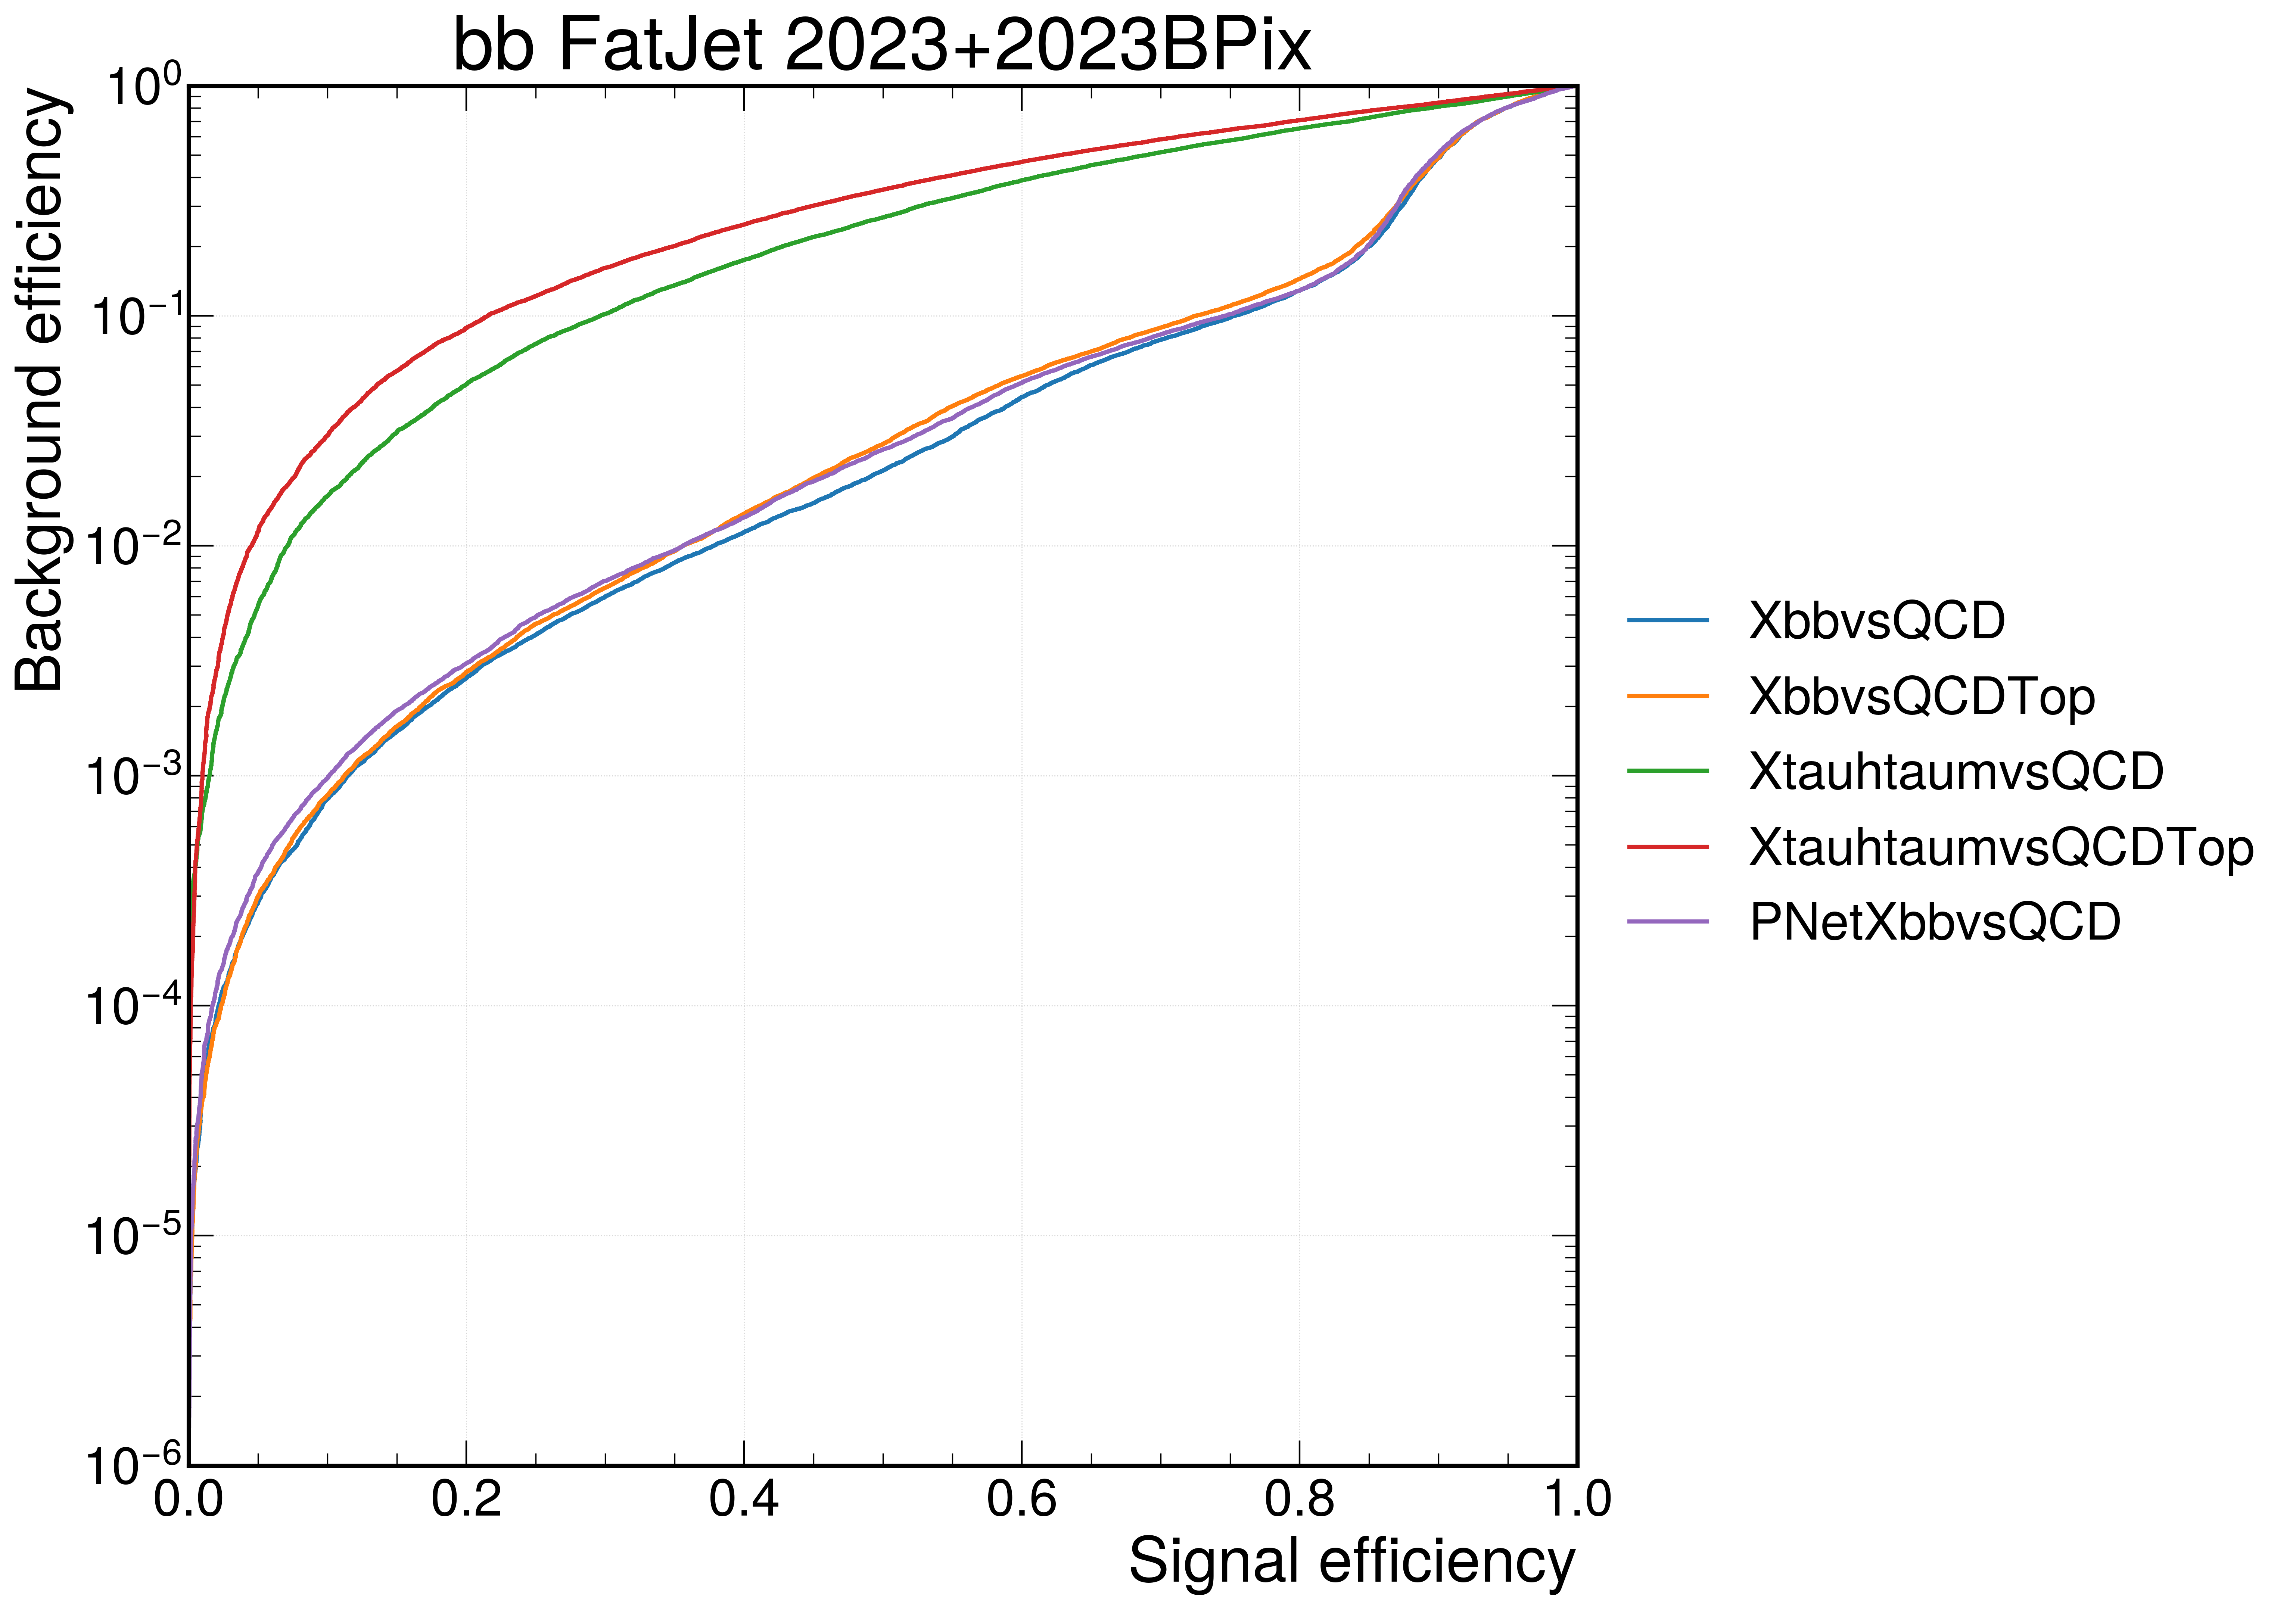

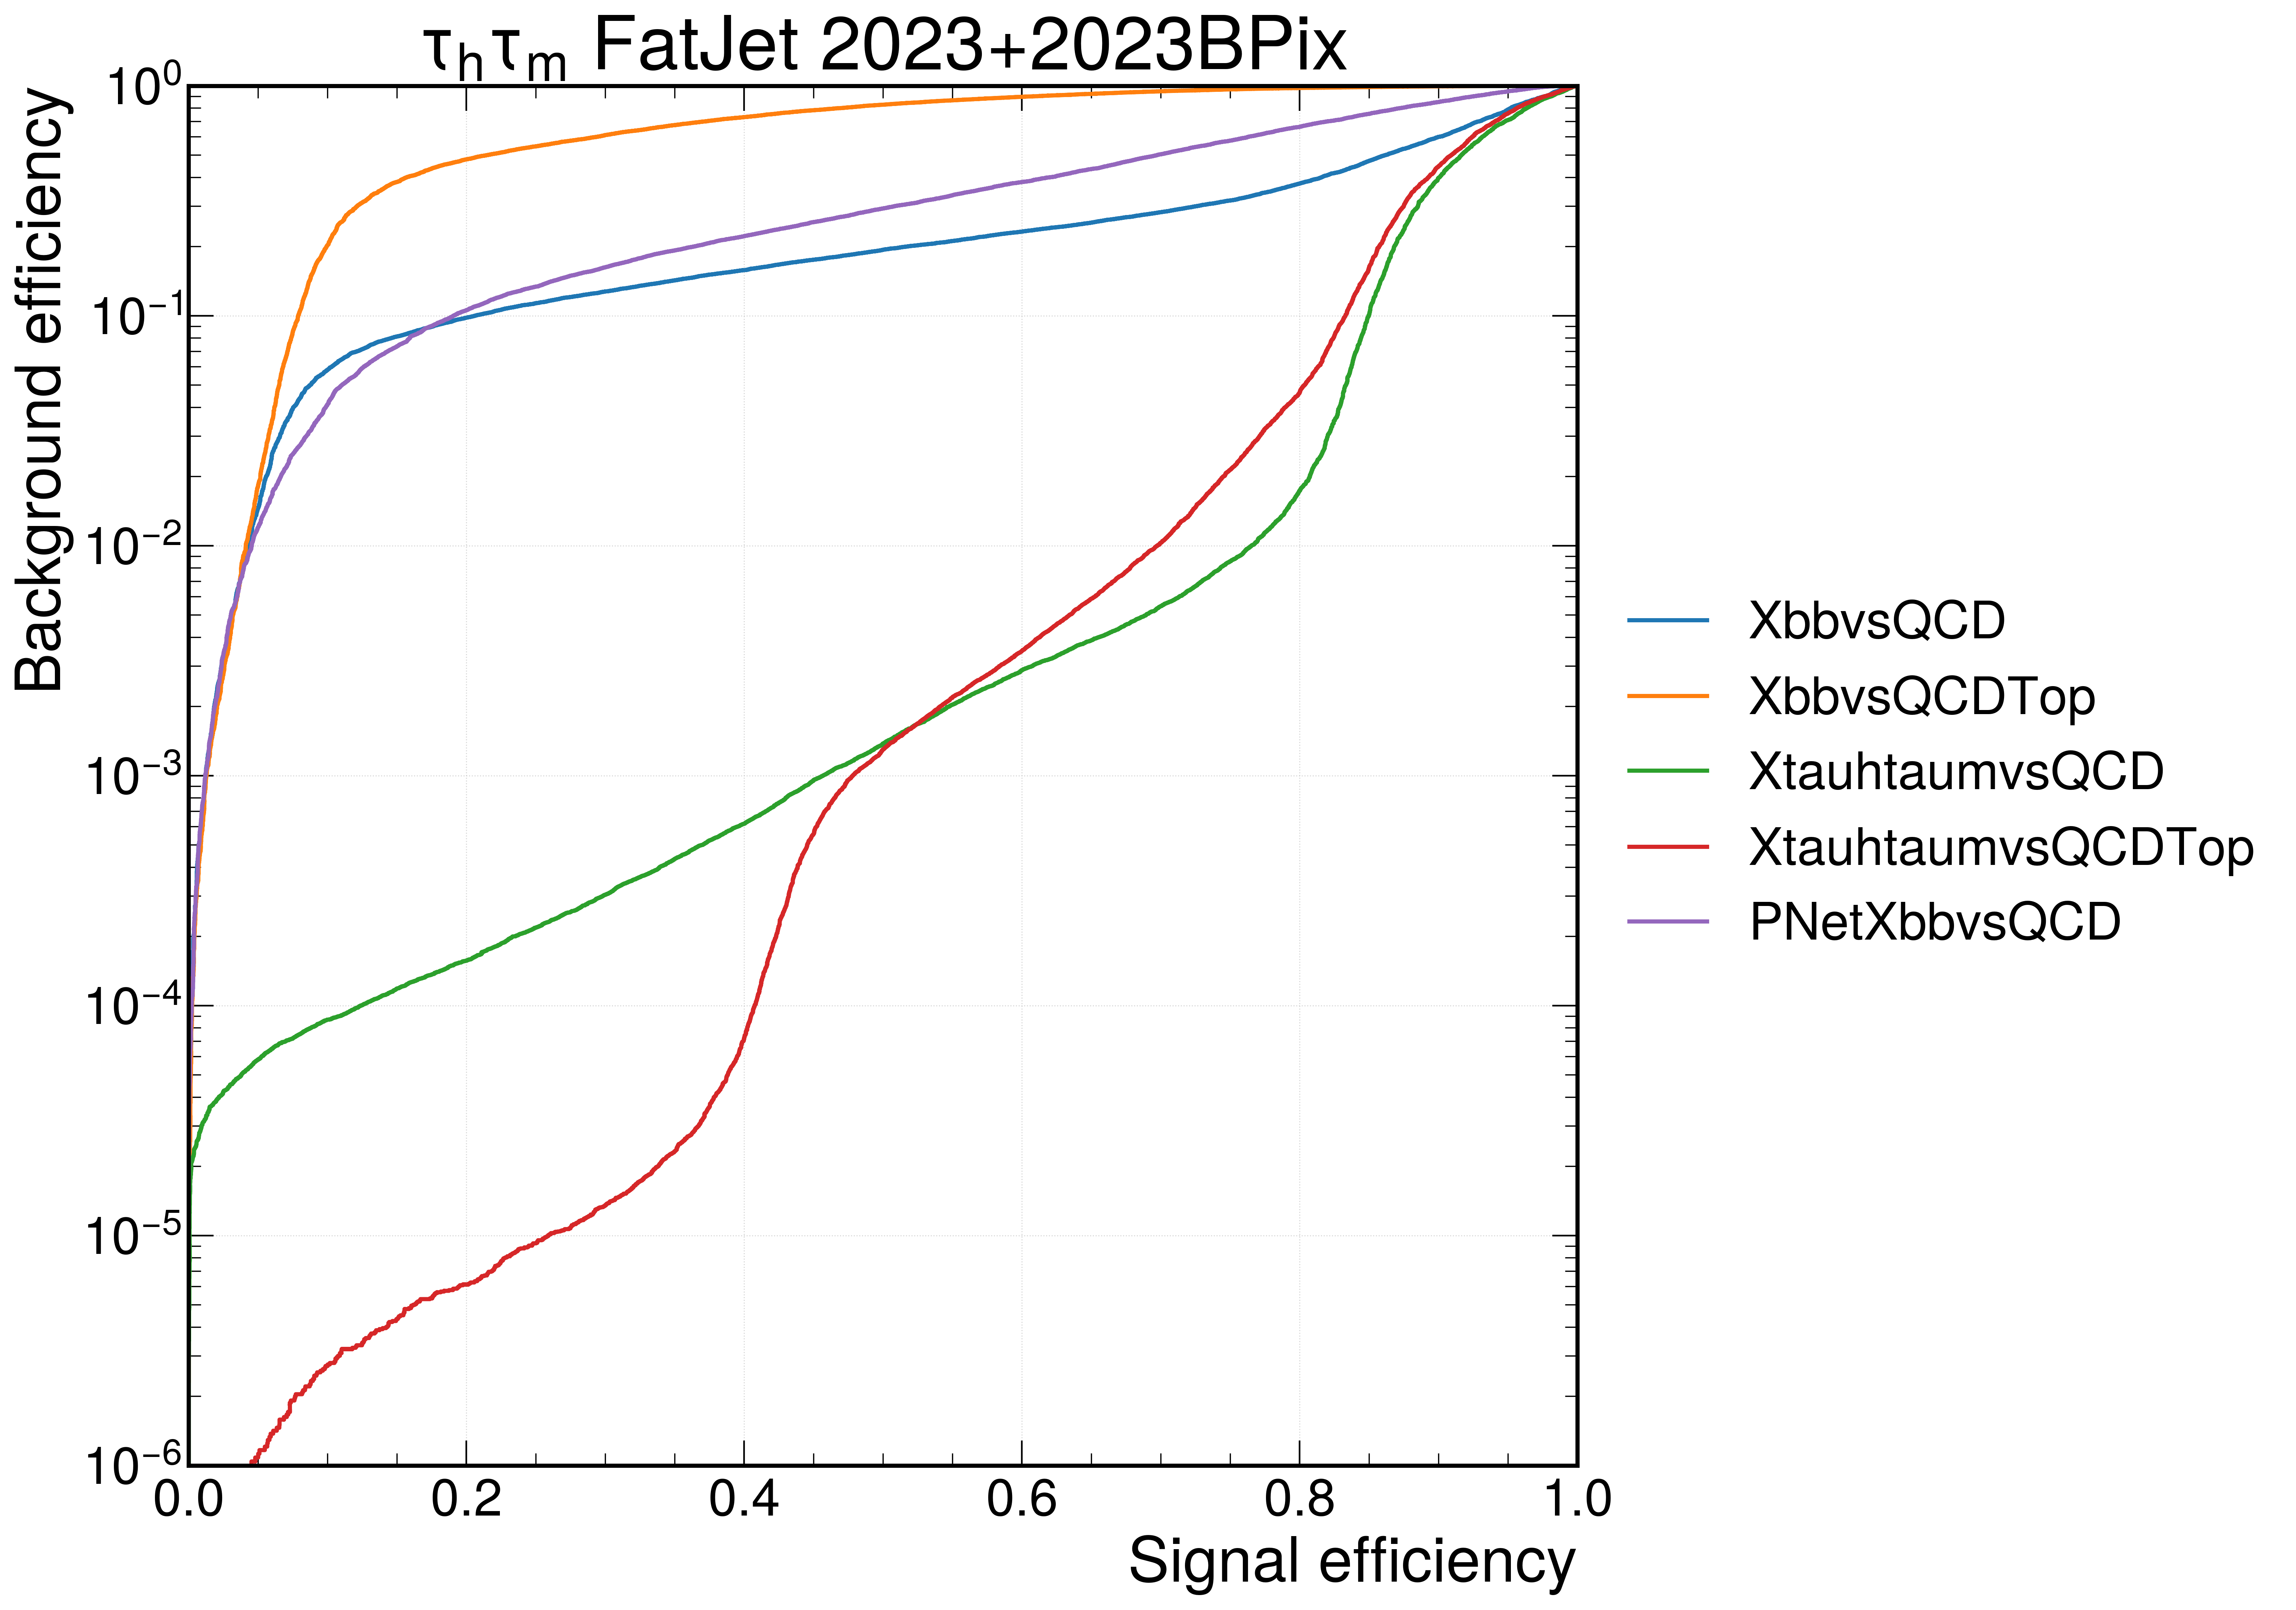

In [ ]:
for jet, title in zip(["bb", "tautau"], ["bb FatJet", rf"$\tau_h\tau_{CHANNEL[0]}$ FatJet"]):
    if len(years) > 1:
        for i, year in enumerate(years):
            if i == 0:
                title += f" {year}"
            else:
                title += f"+{year}"
    else:
        title = title + f" {years[0]}"

    plotting.multiROCCurveGrey(
        {"": rocs_full[jet]},
        title=title,
        show=True,
        plot_dir=plot_dir,
        name=f"roc_{jet} {years}",
    )

In [ ]:
rocs = {year: compute_rocs([year]) for year in years}

bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD
bb
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD
tautau
	XbbvsQCD
	XbbvsQCDTop
	XtauhtaumvsQCD
	XtauhtaumvsQCDTop
	PNetXbbvsQCD


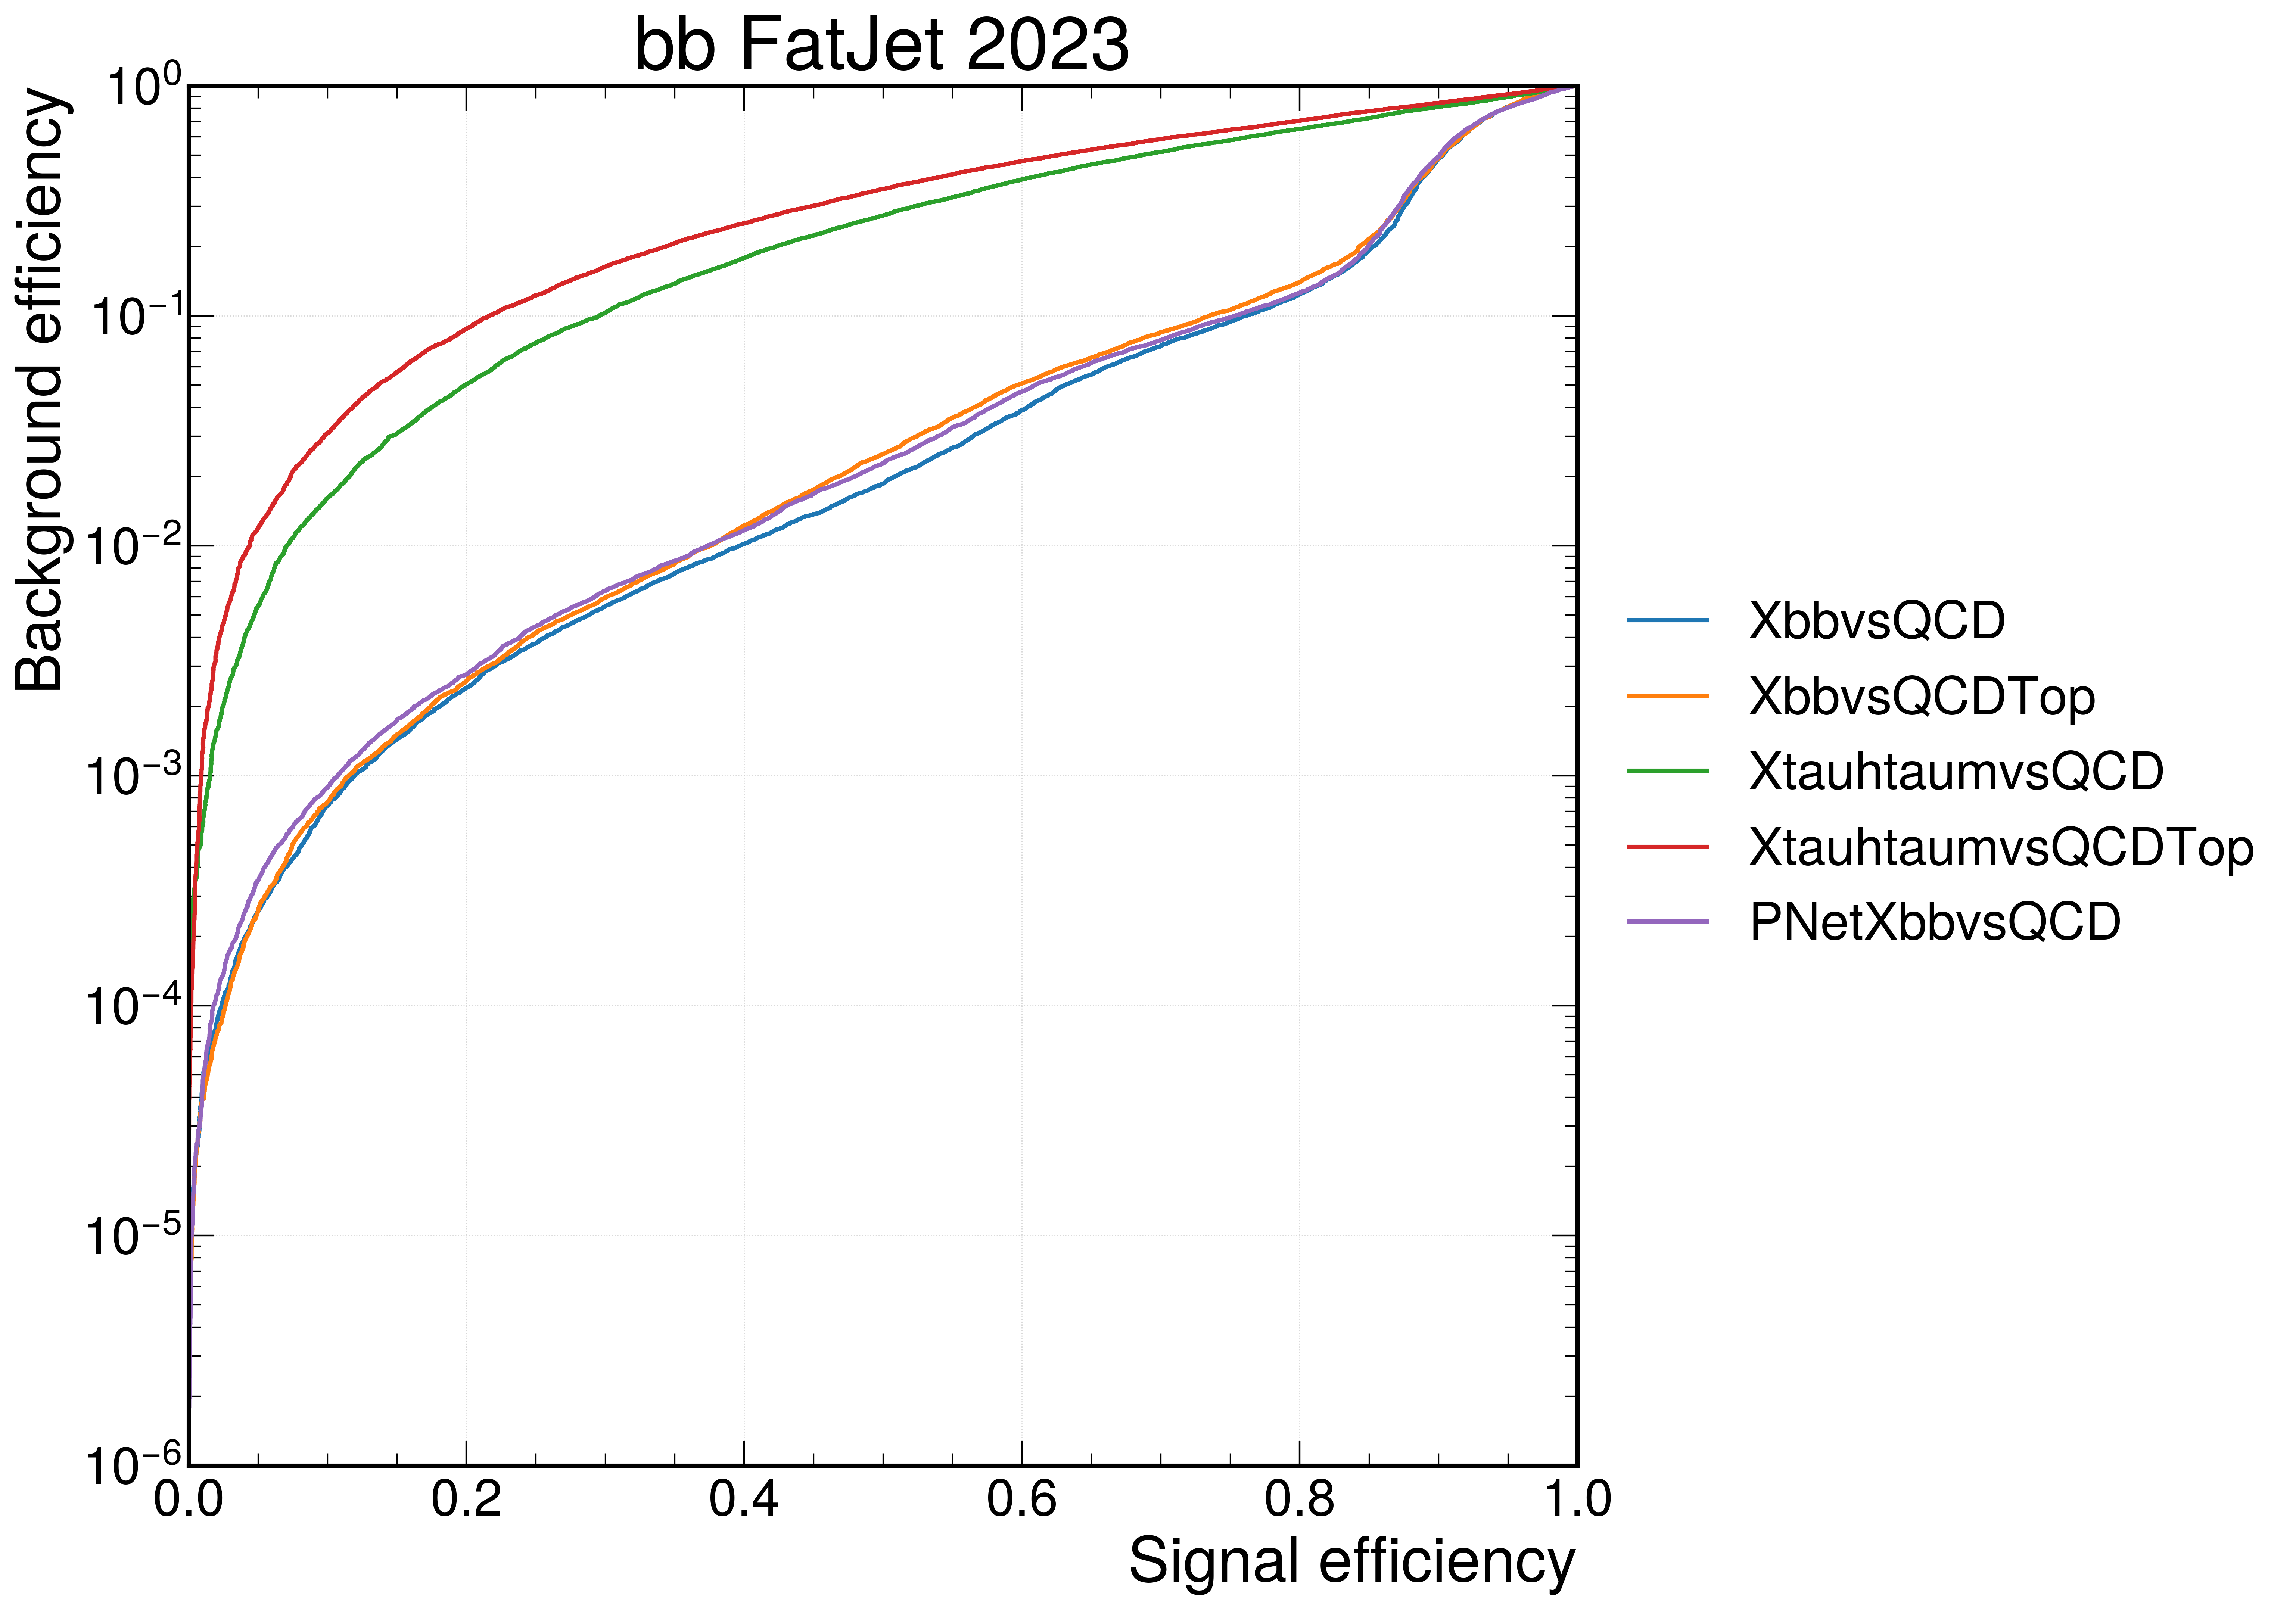

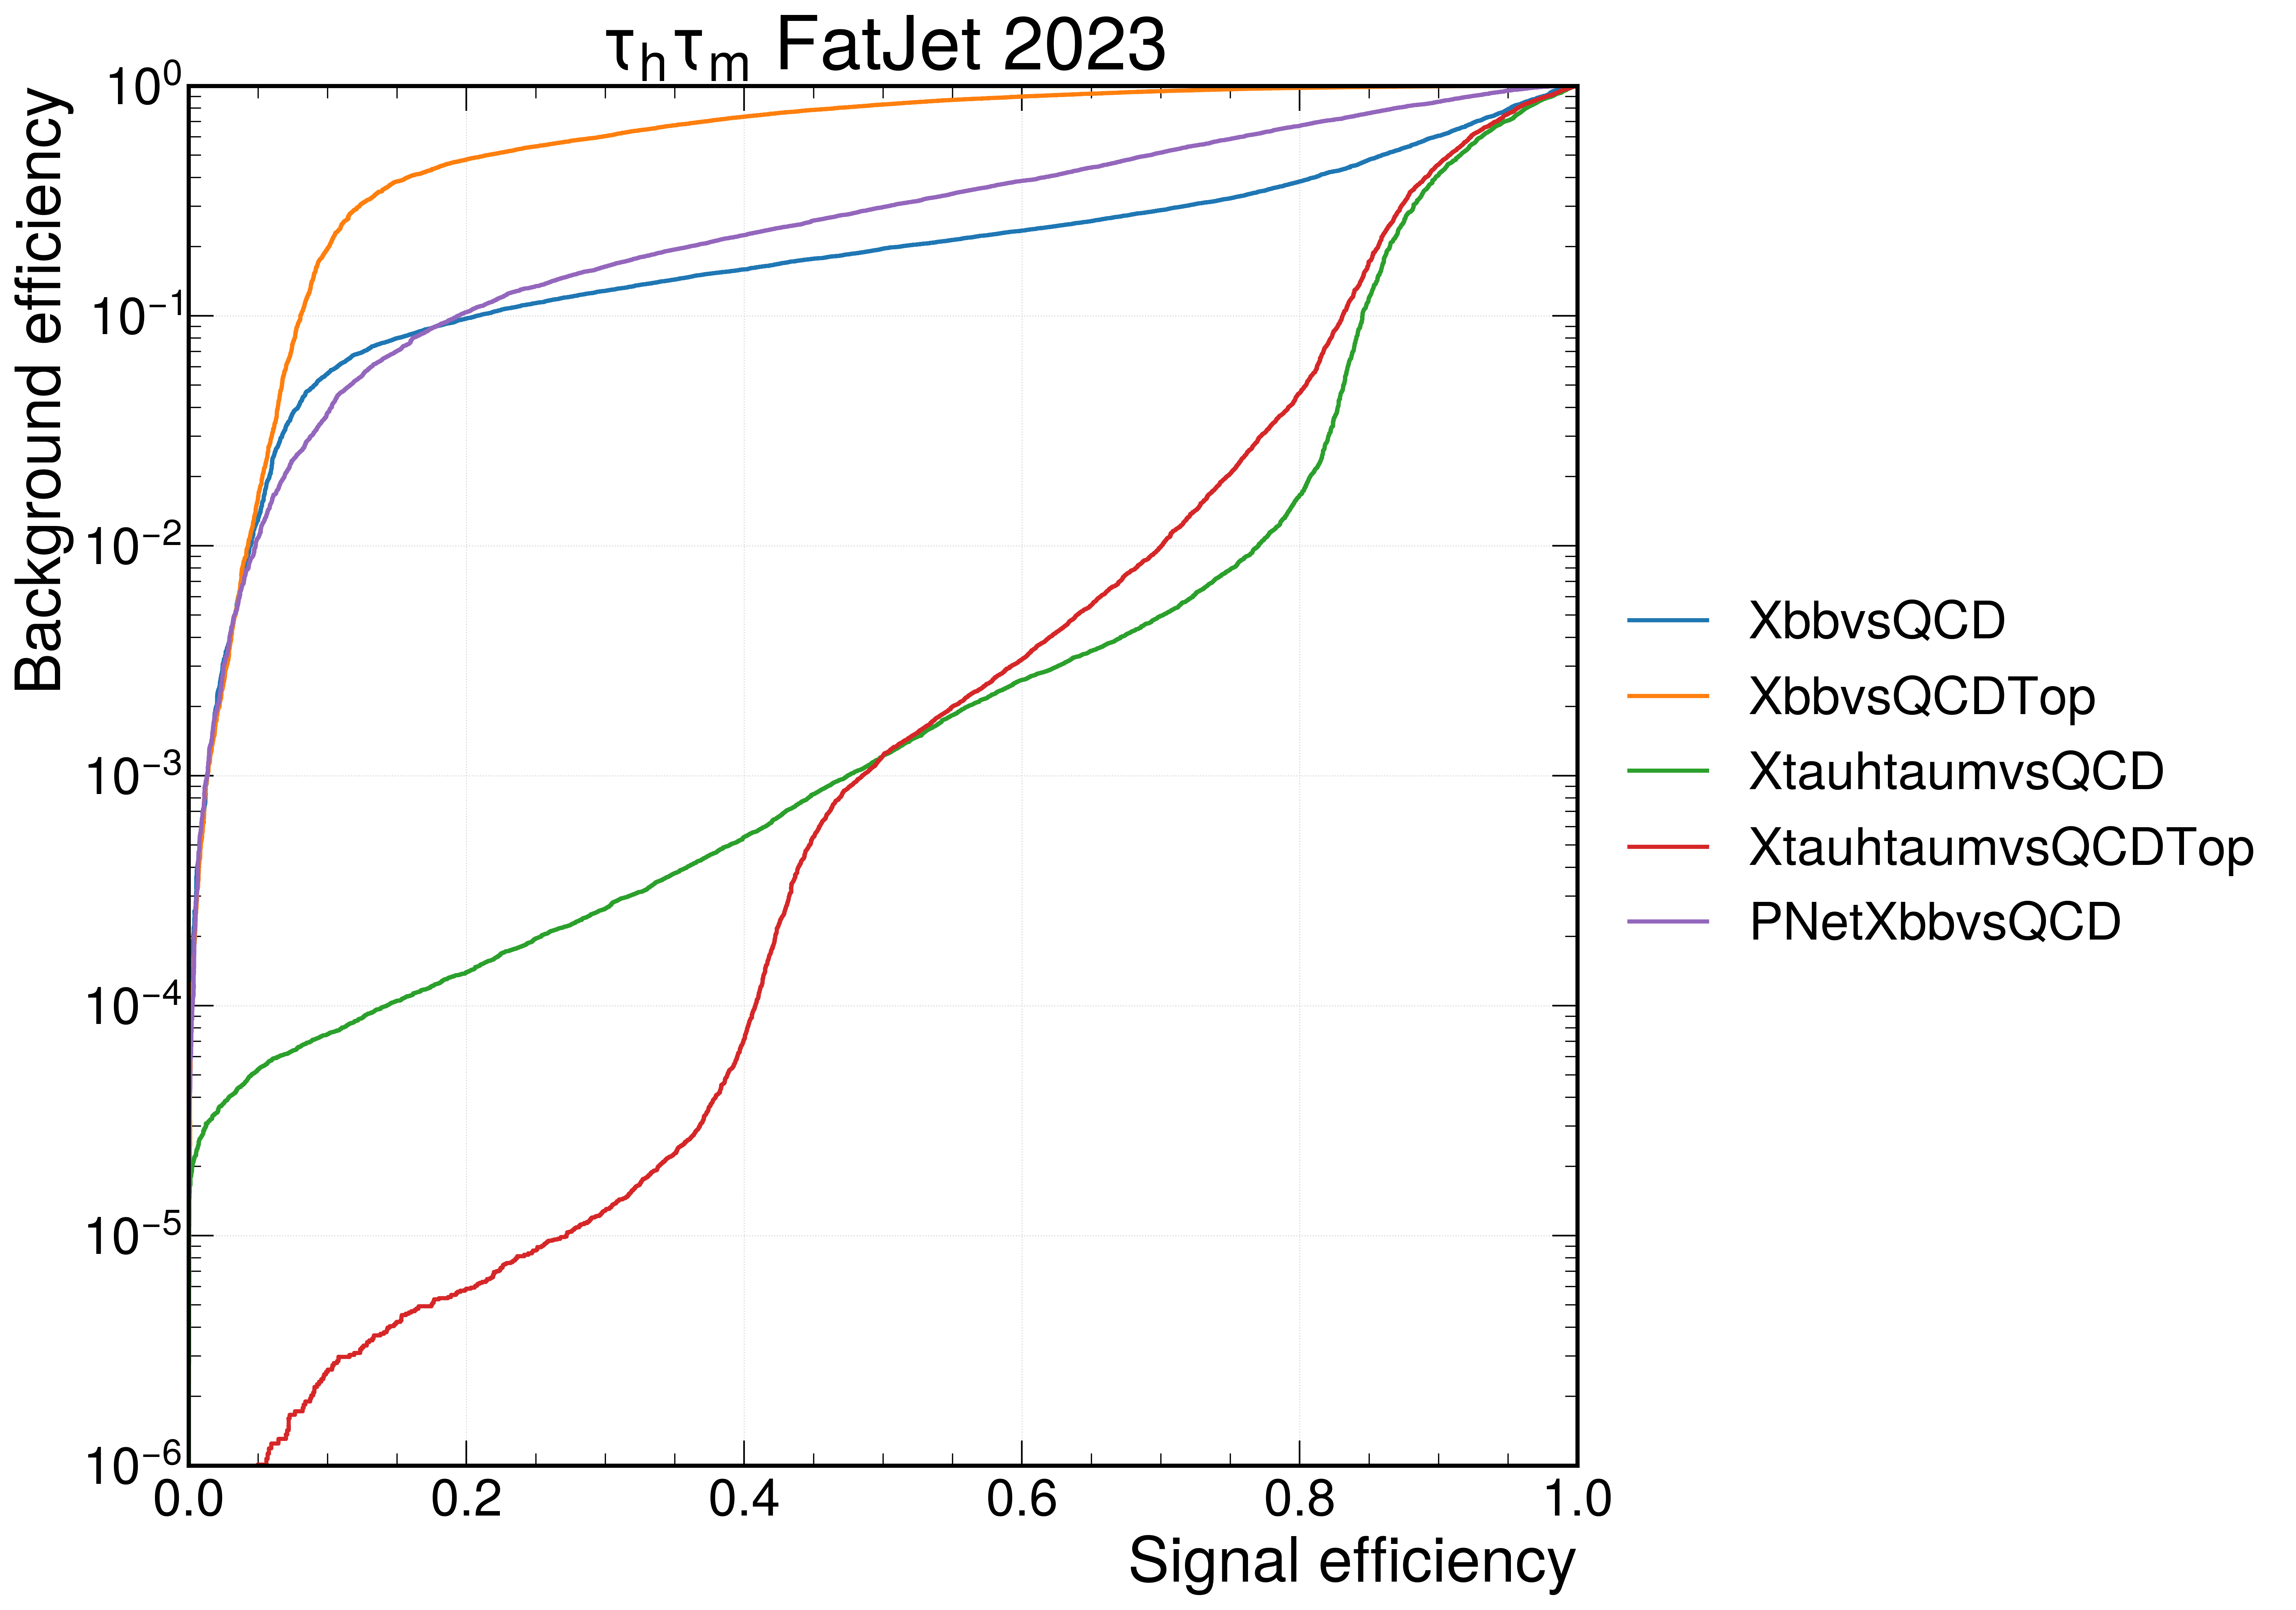

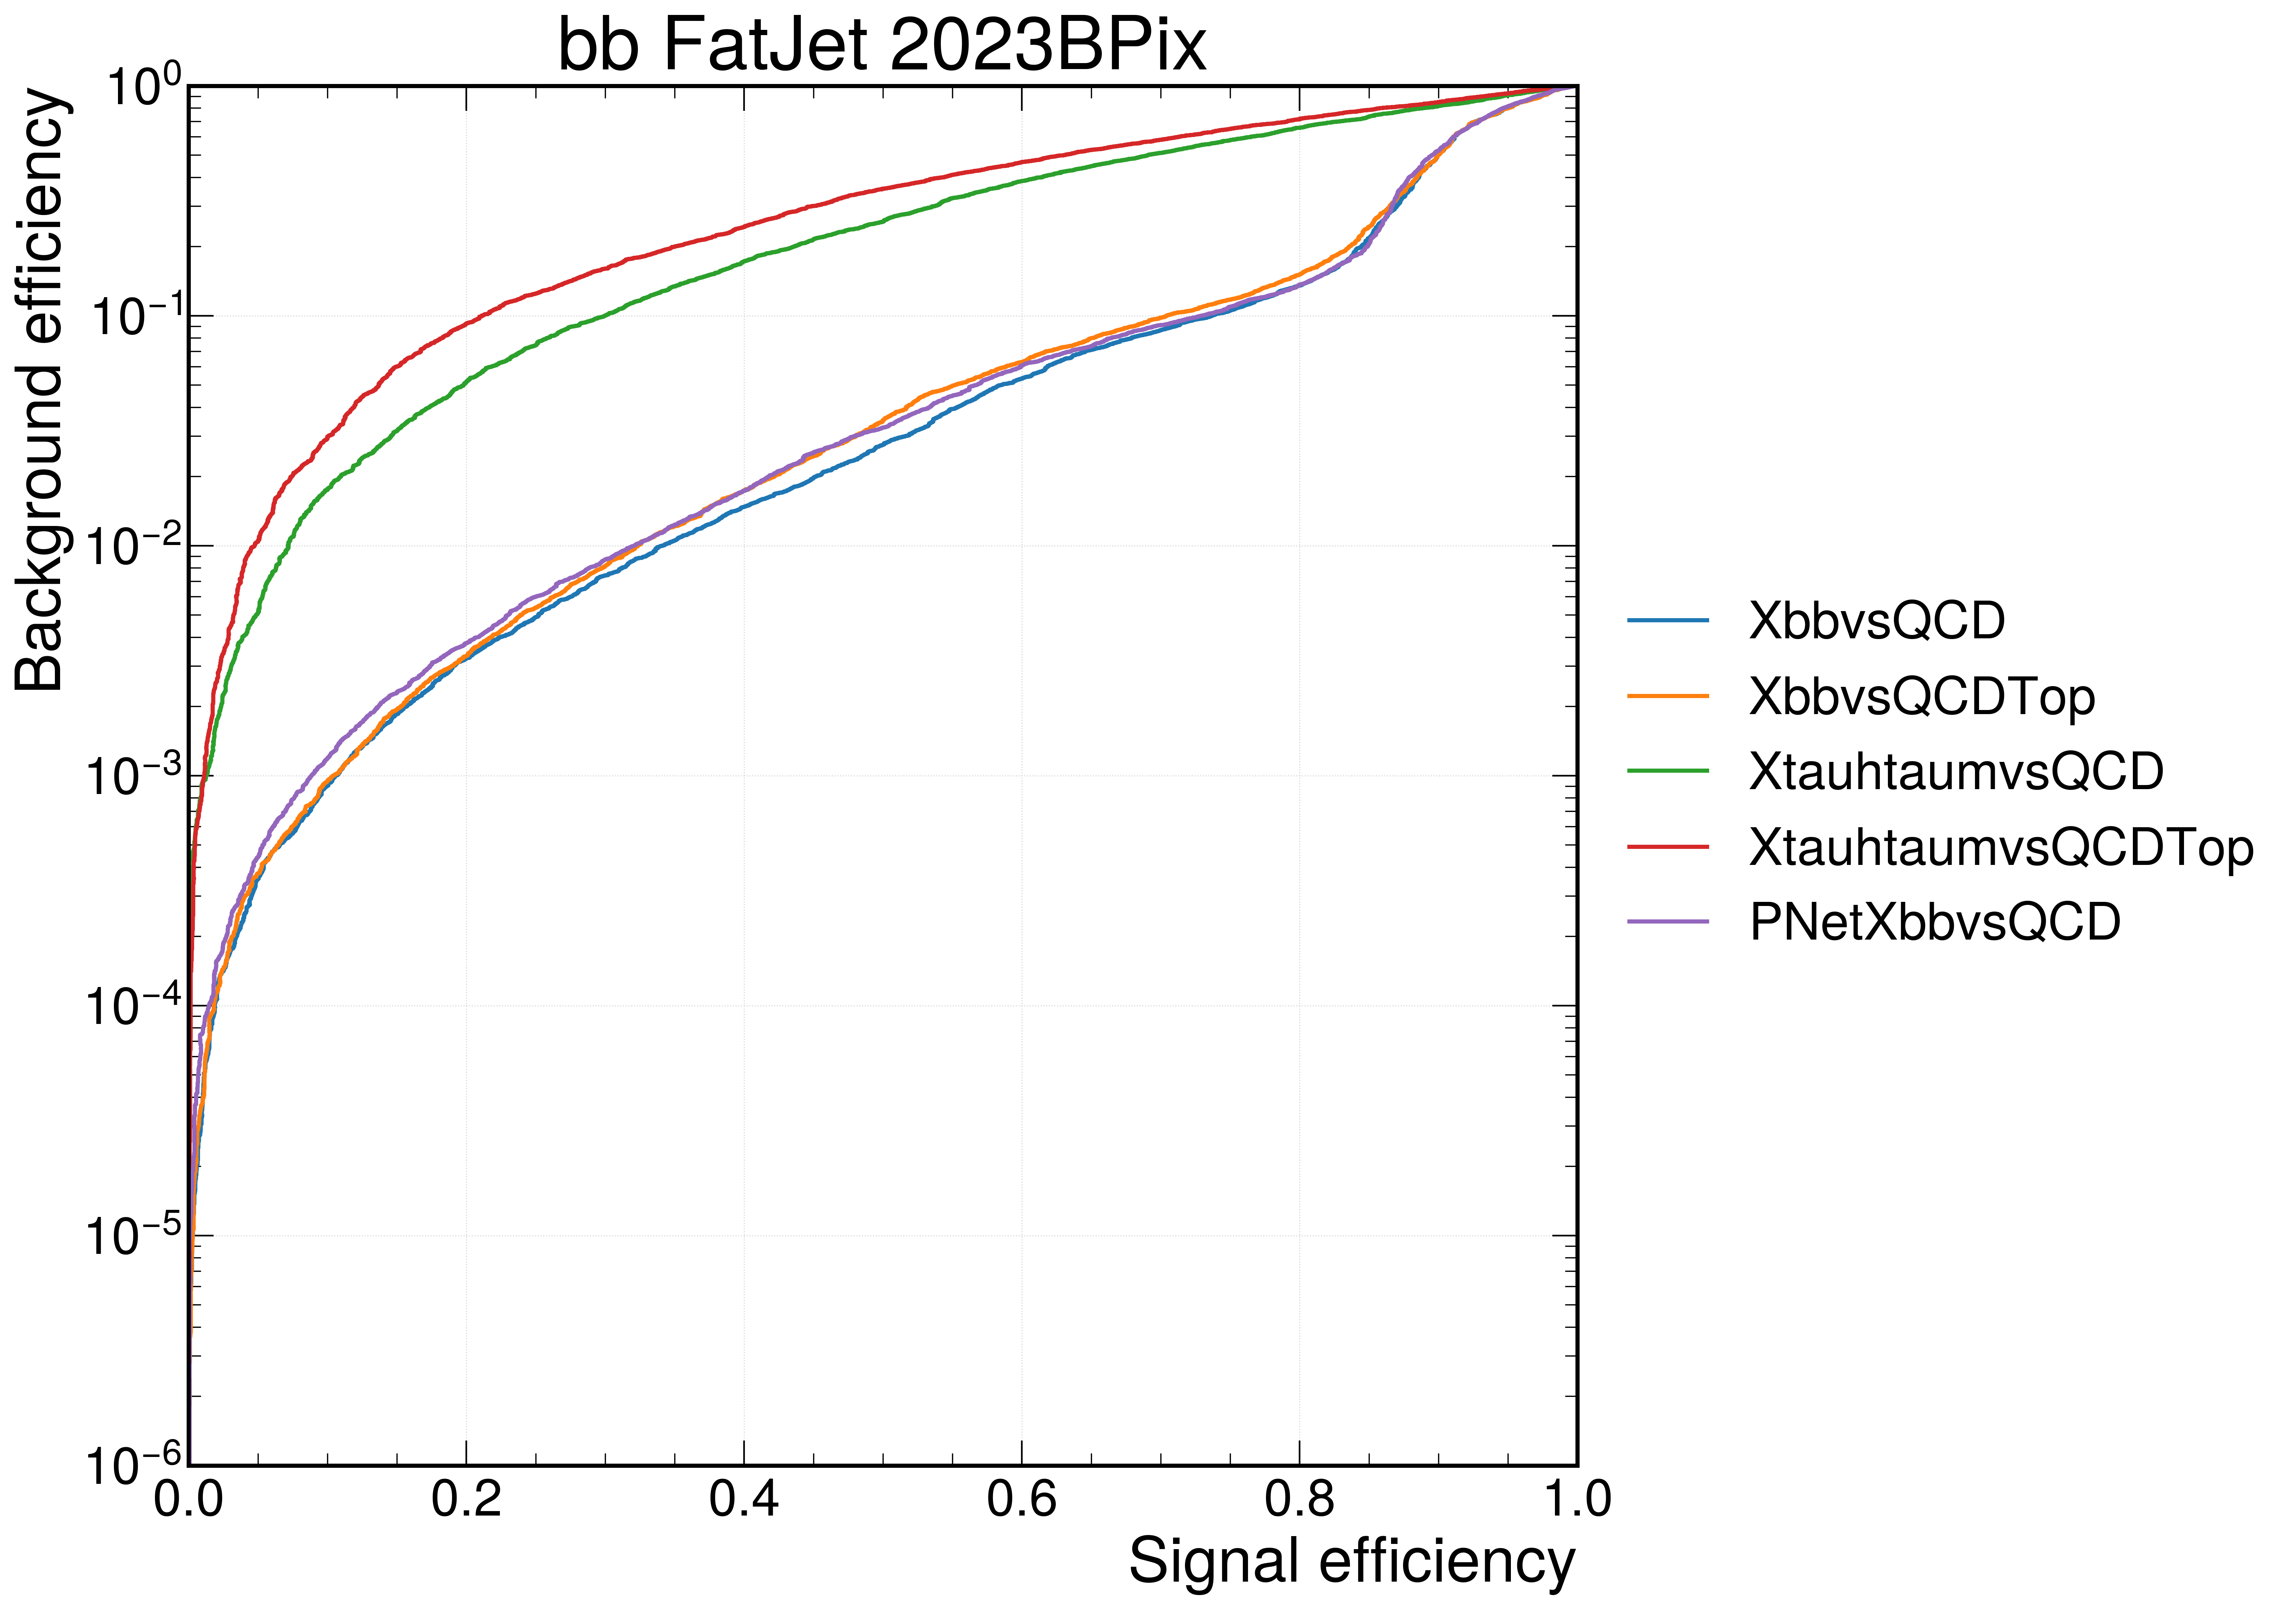

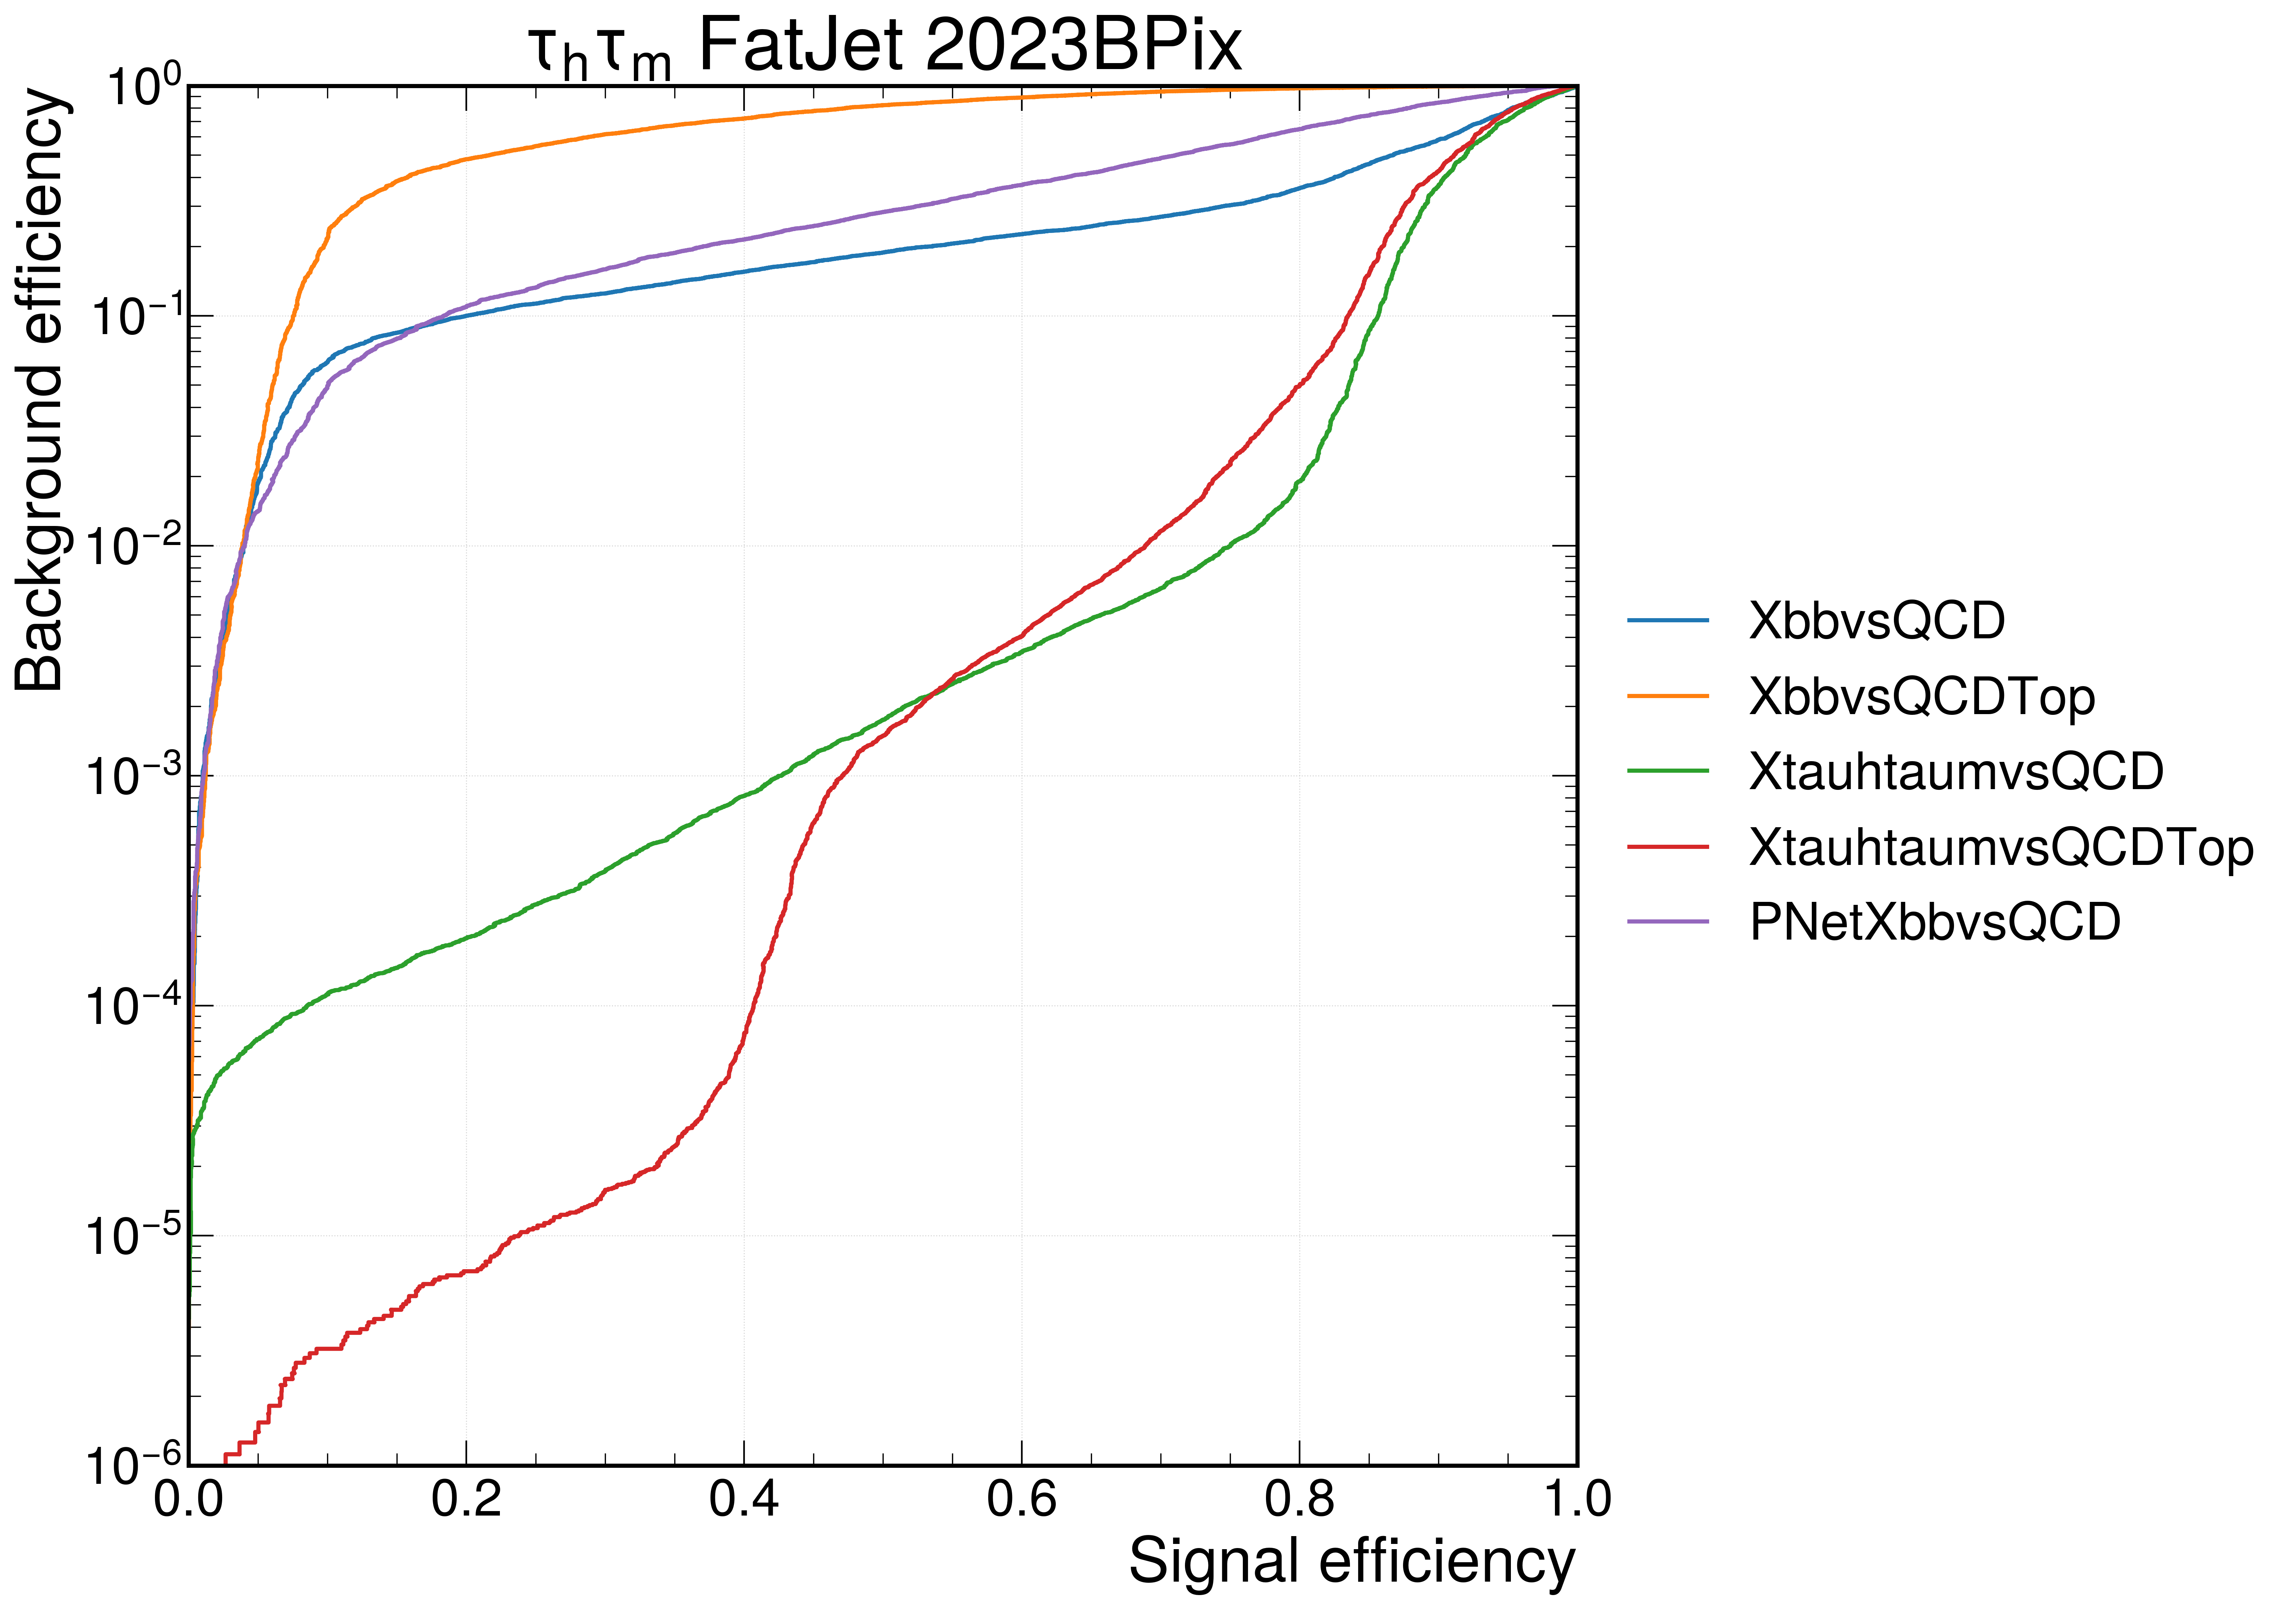

In [ ]:
for year in years:
    for jet, title in zip(["bb", "tautau"], ["bb FatJet", rf"$\tau_h\tau_{CHANNEL[0]}$ FatJet"]):
        plotting.multiROCCurveGrey(
            {"": rocs[year][jet]},
            title=title + " " + year,
            show=True,
            plot_dir=plot_dir,
            name=f"roc_{jet} {year}",
        )

## Mass

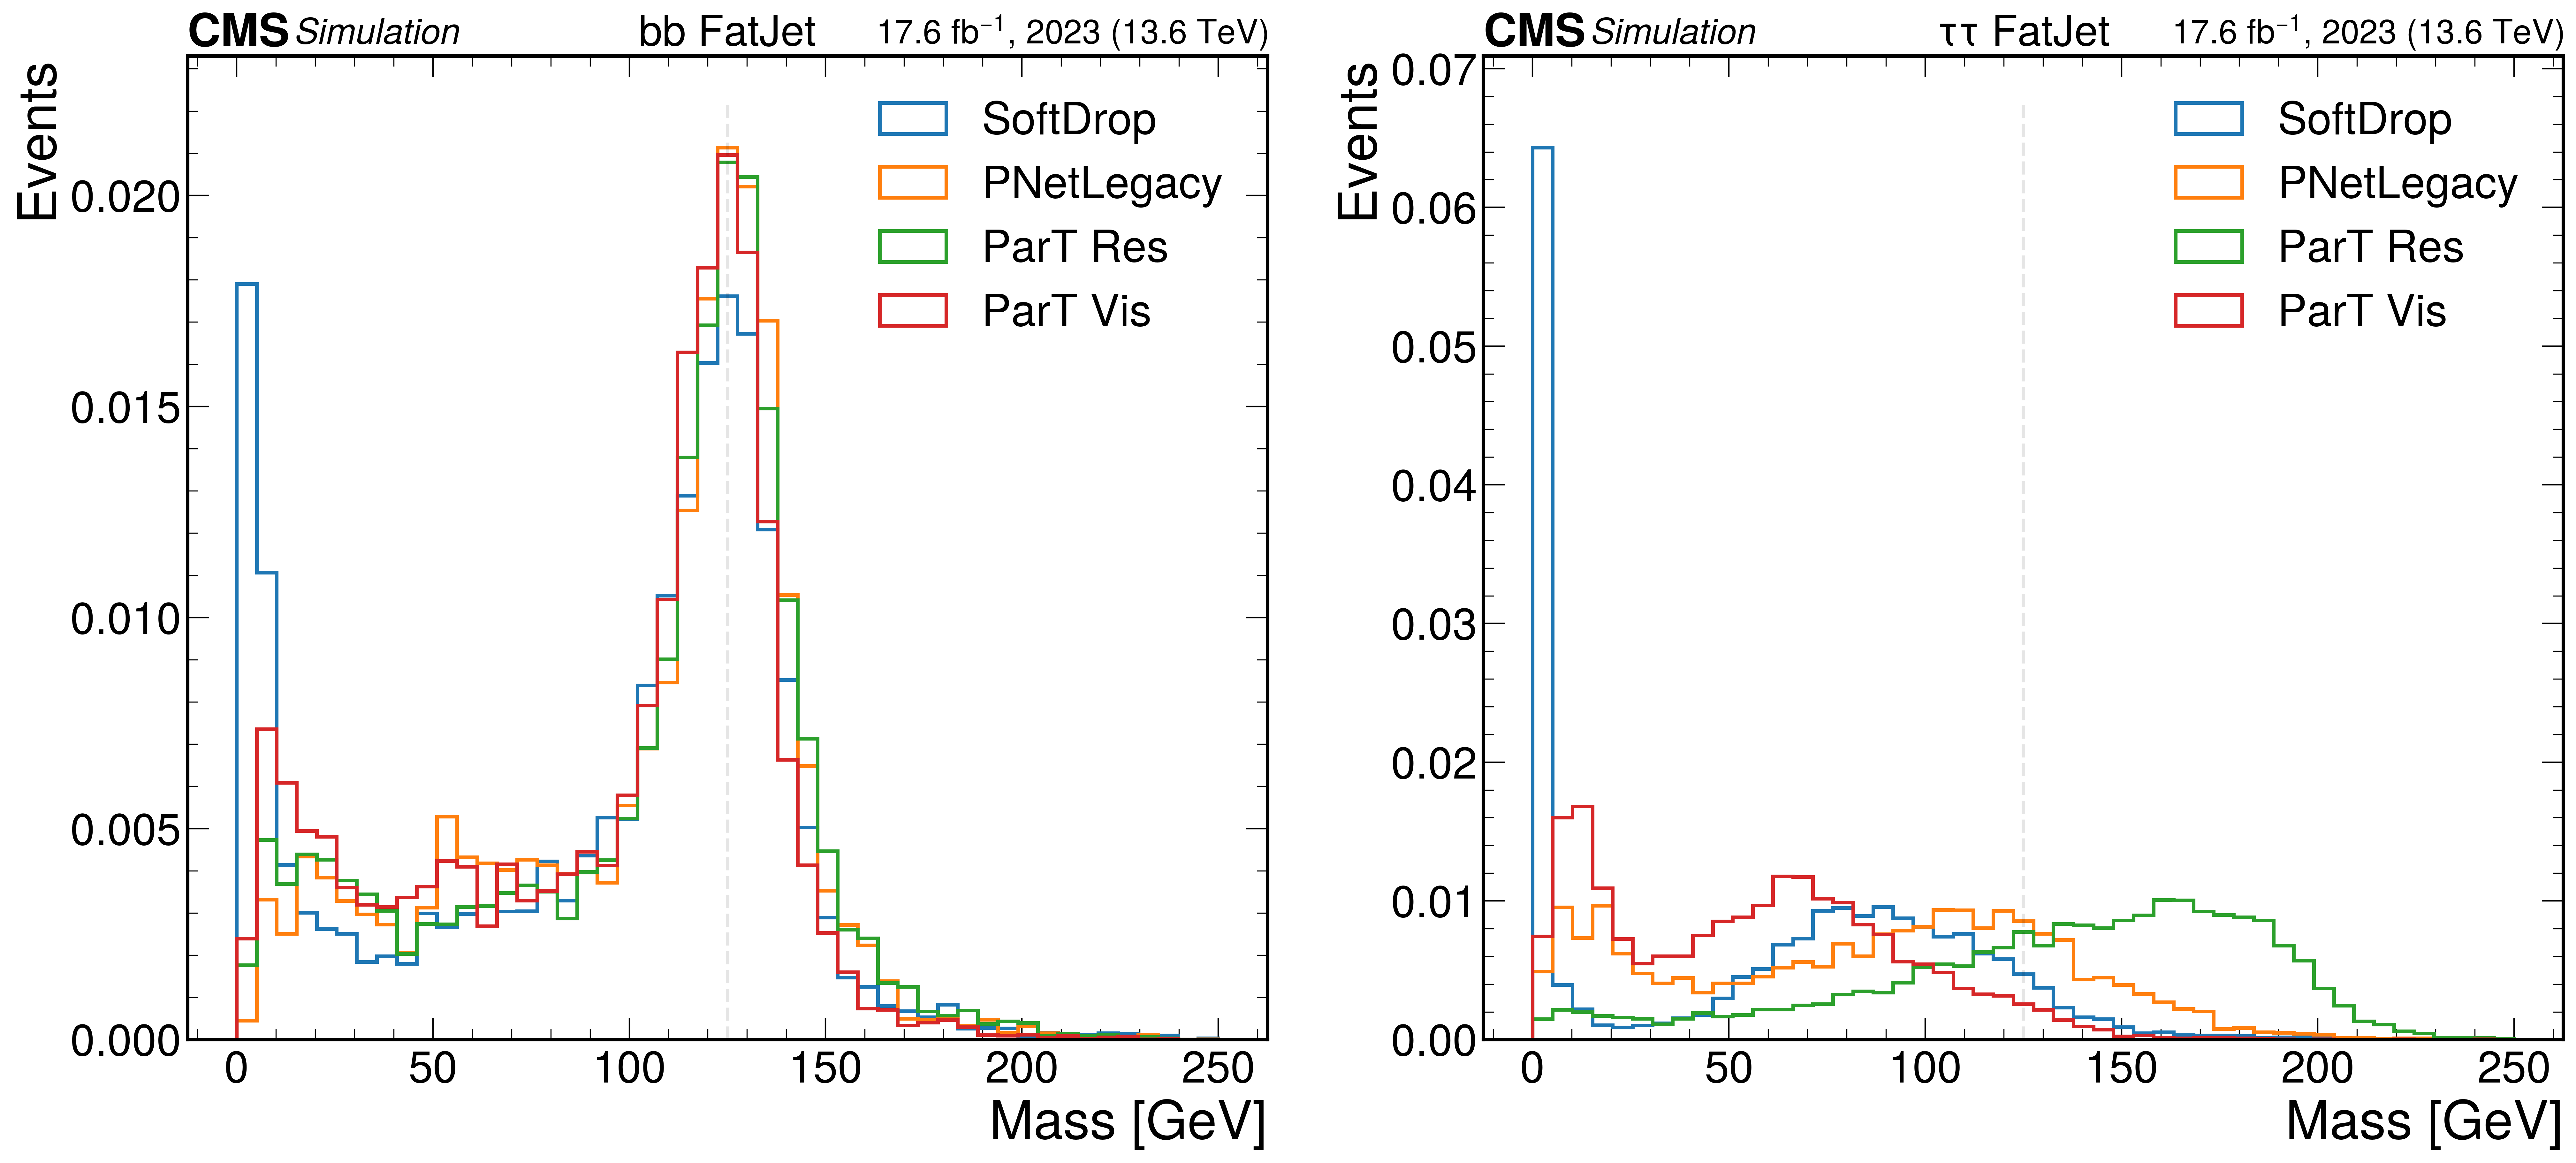

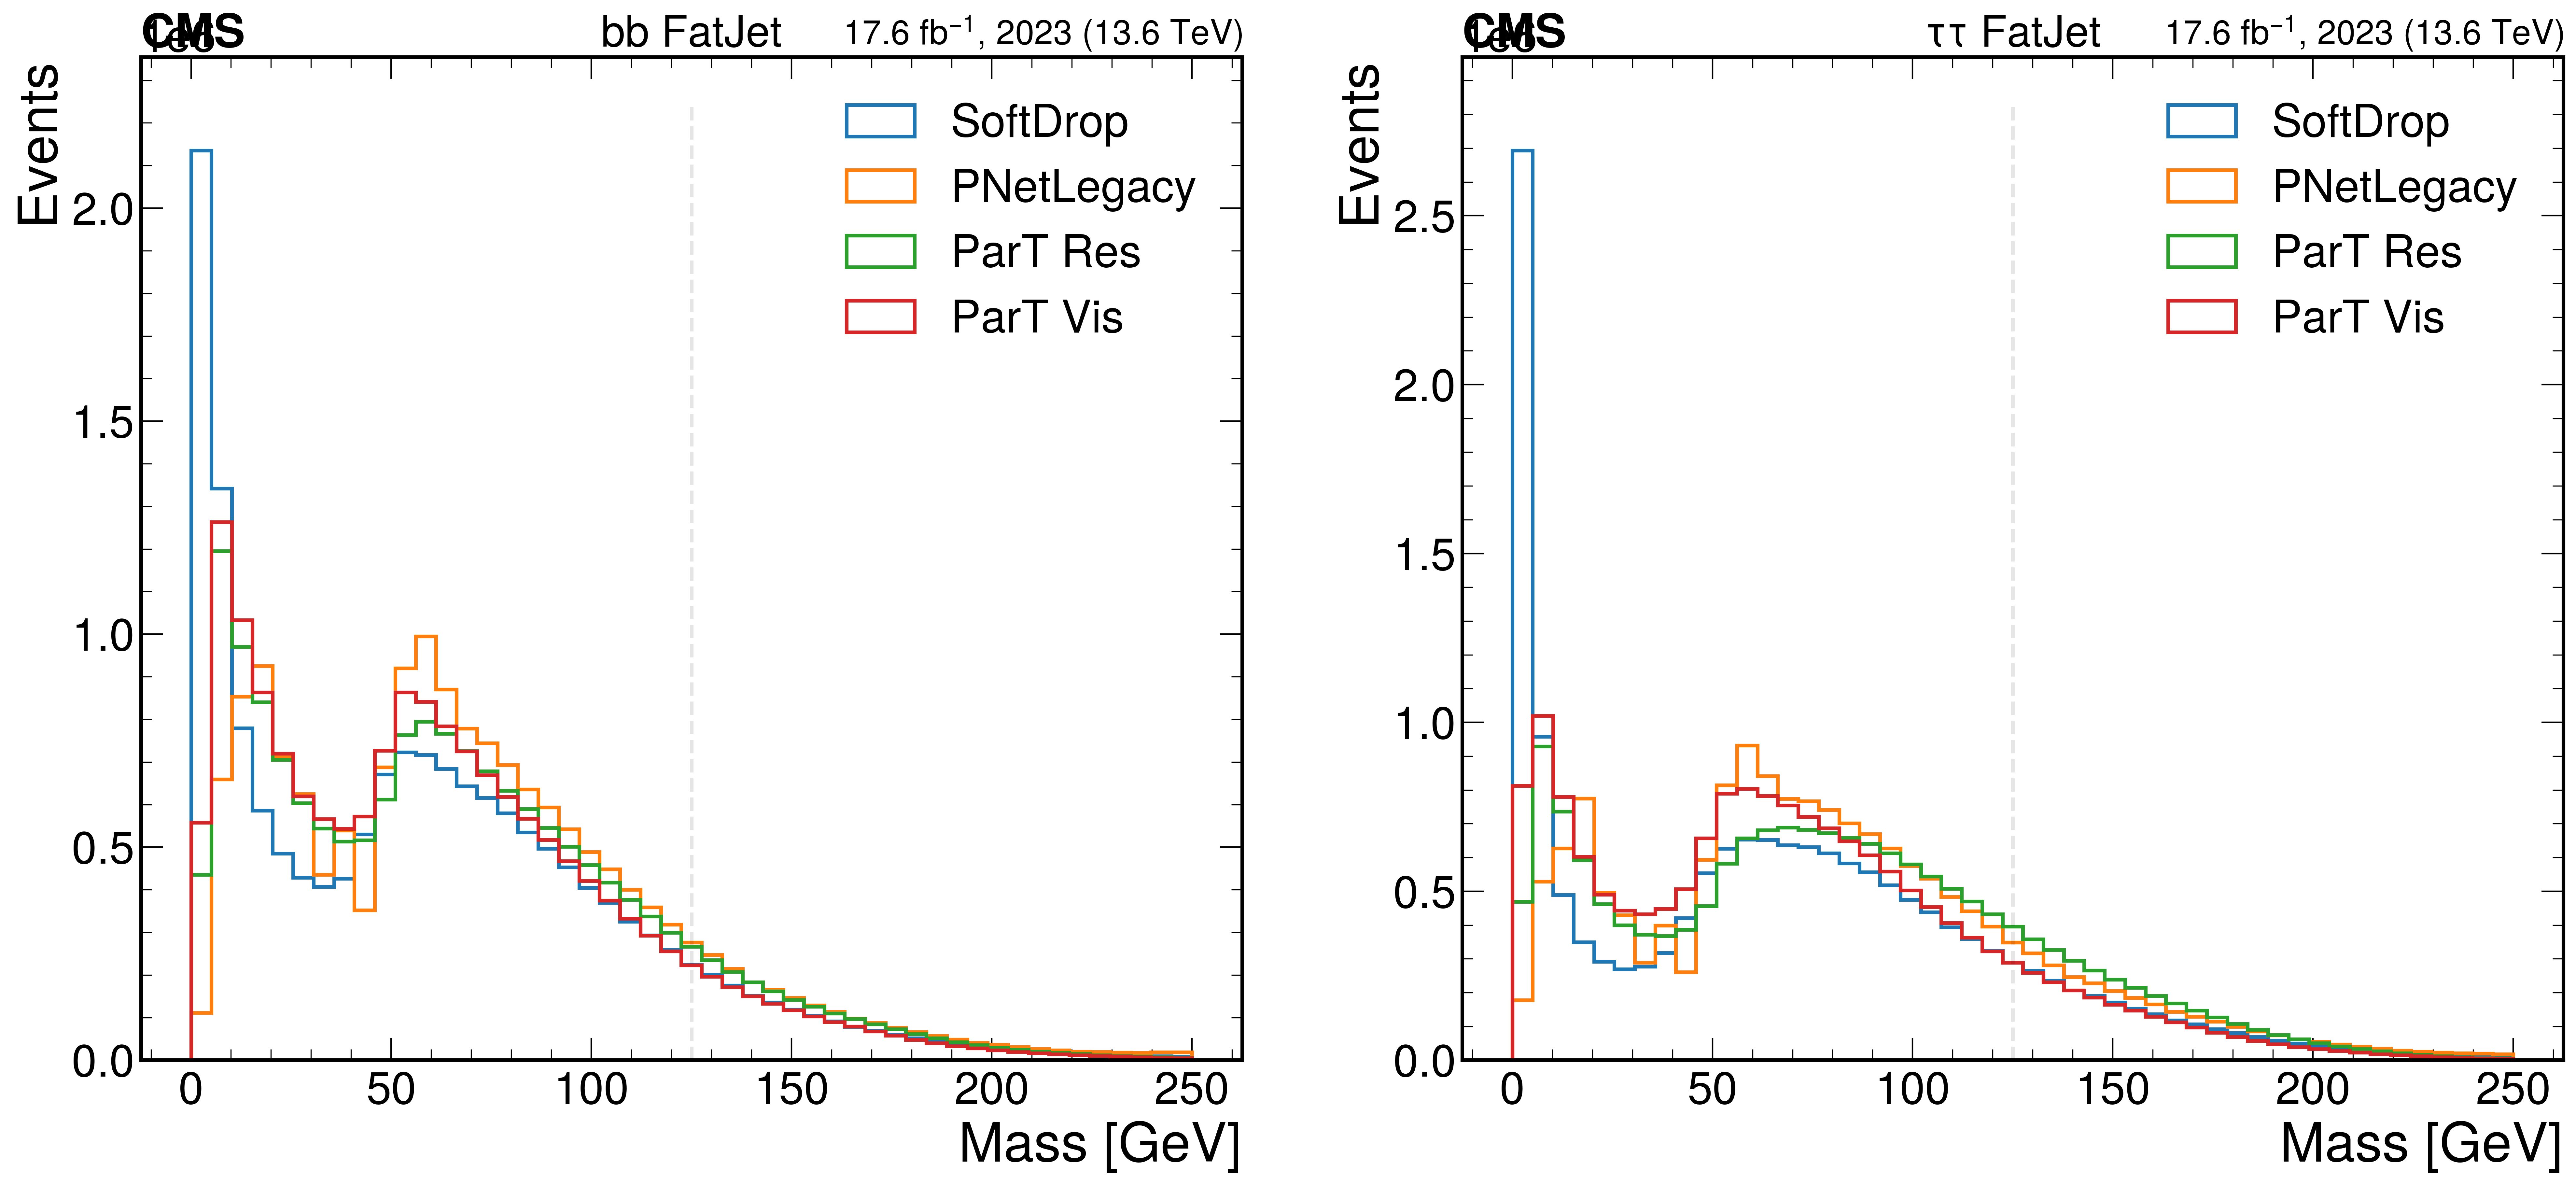

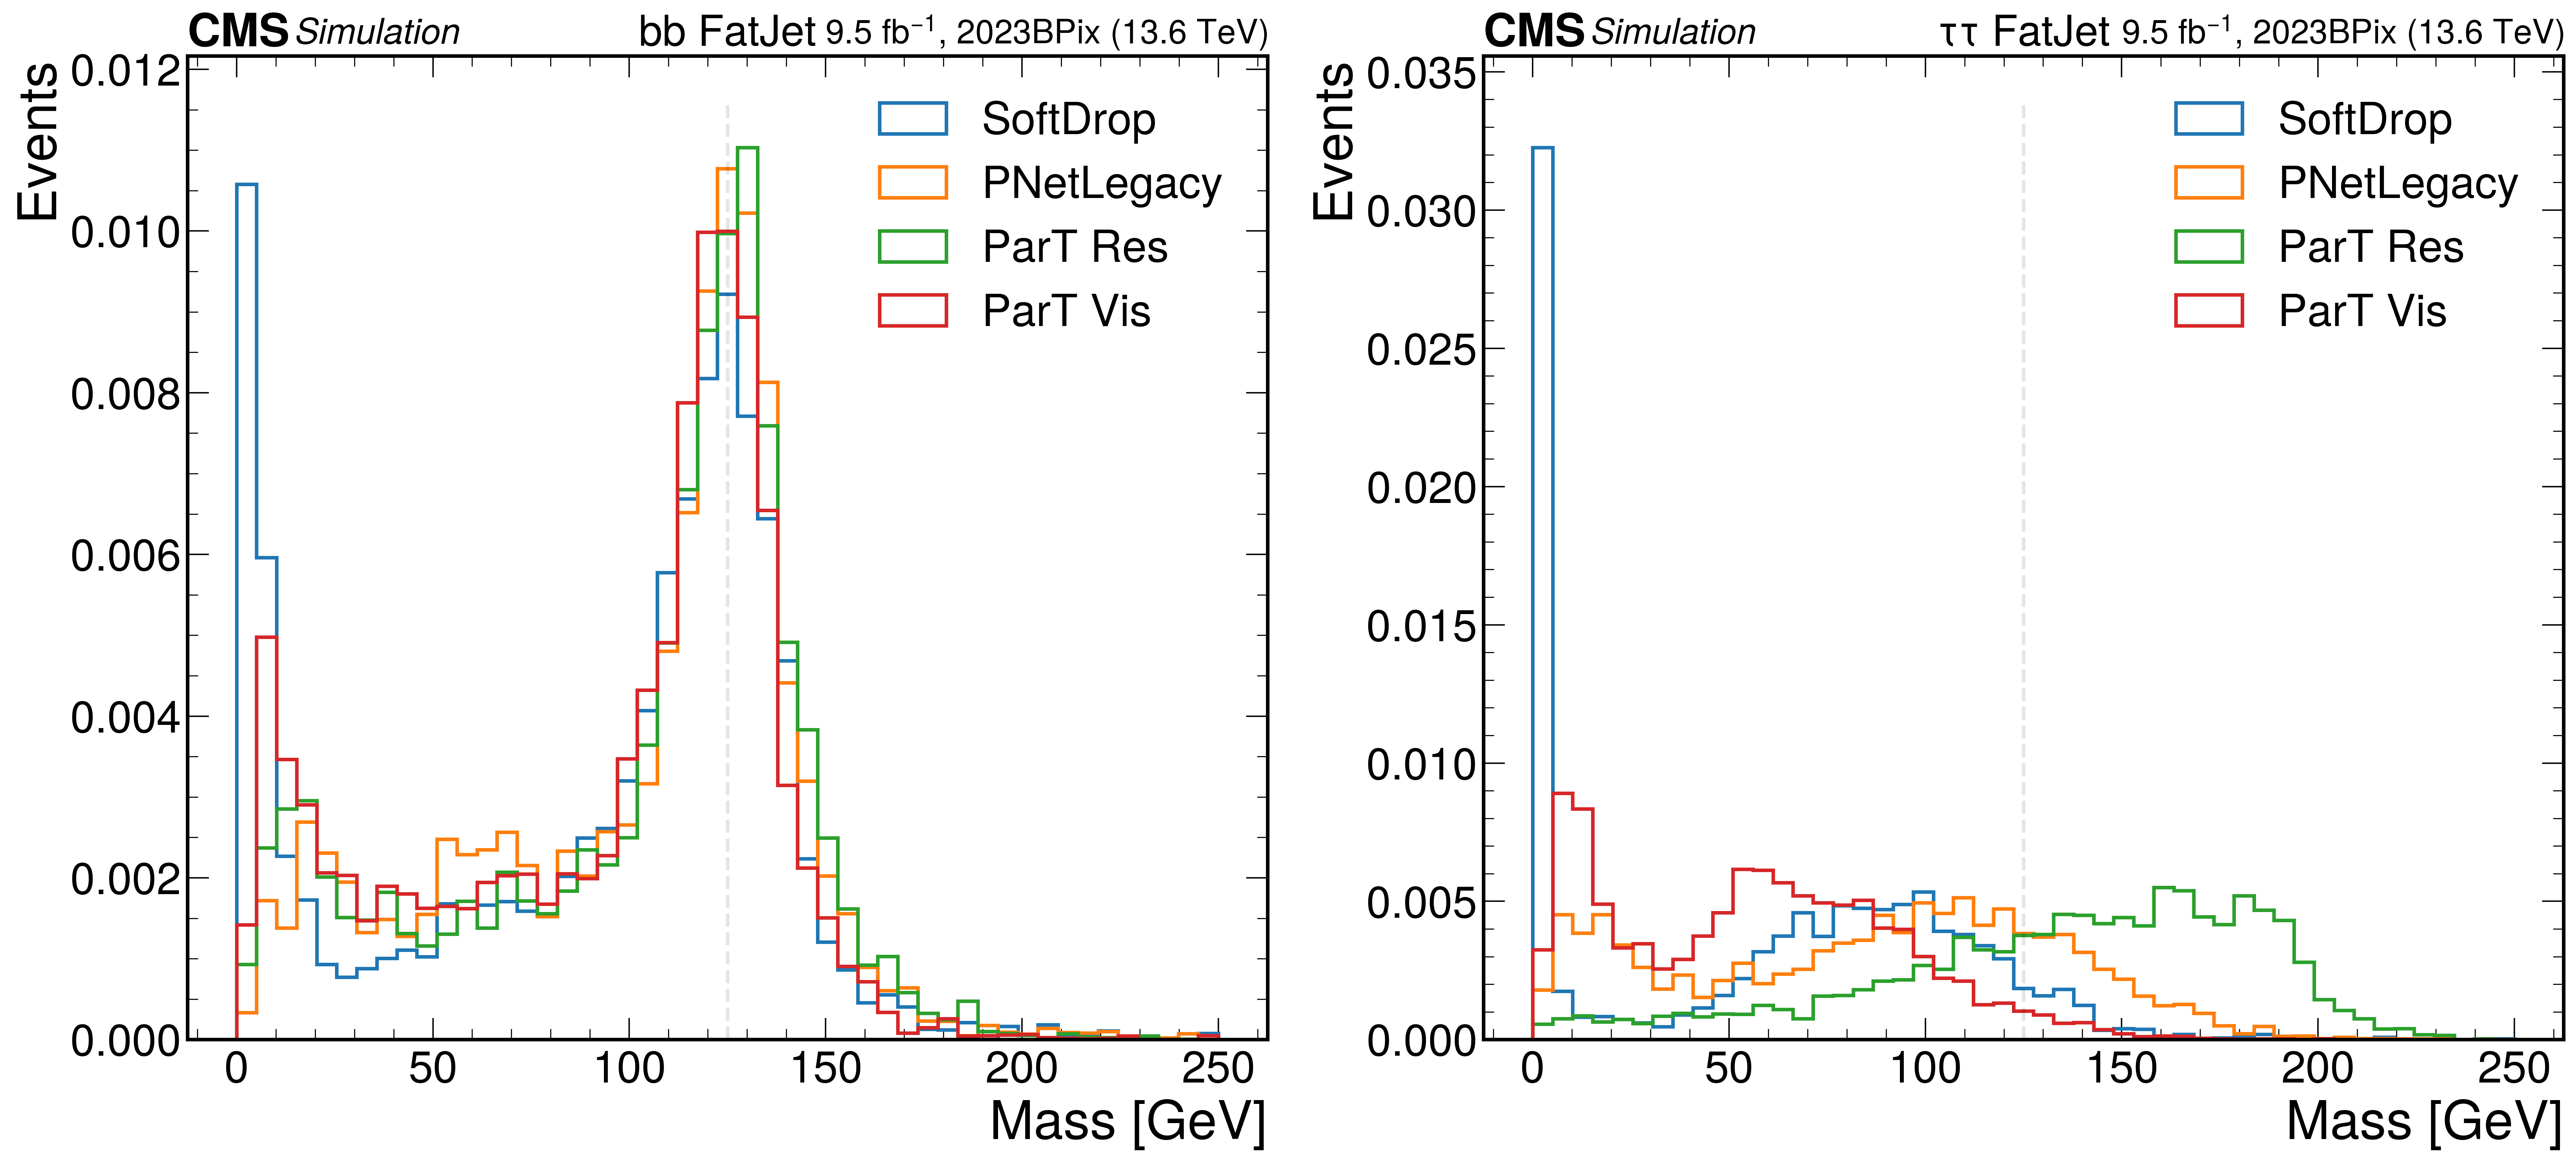

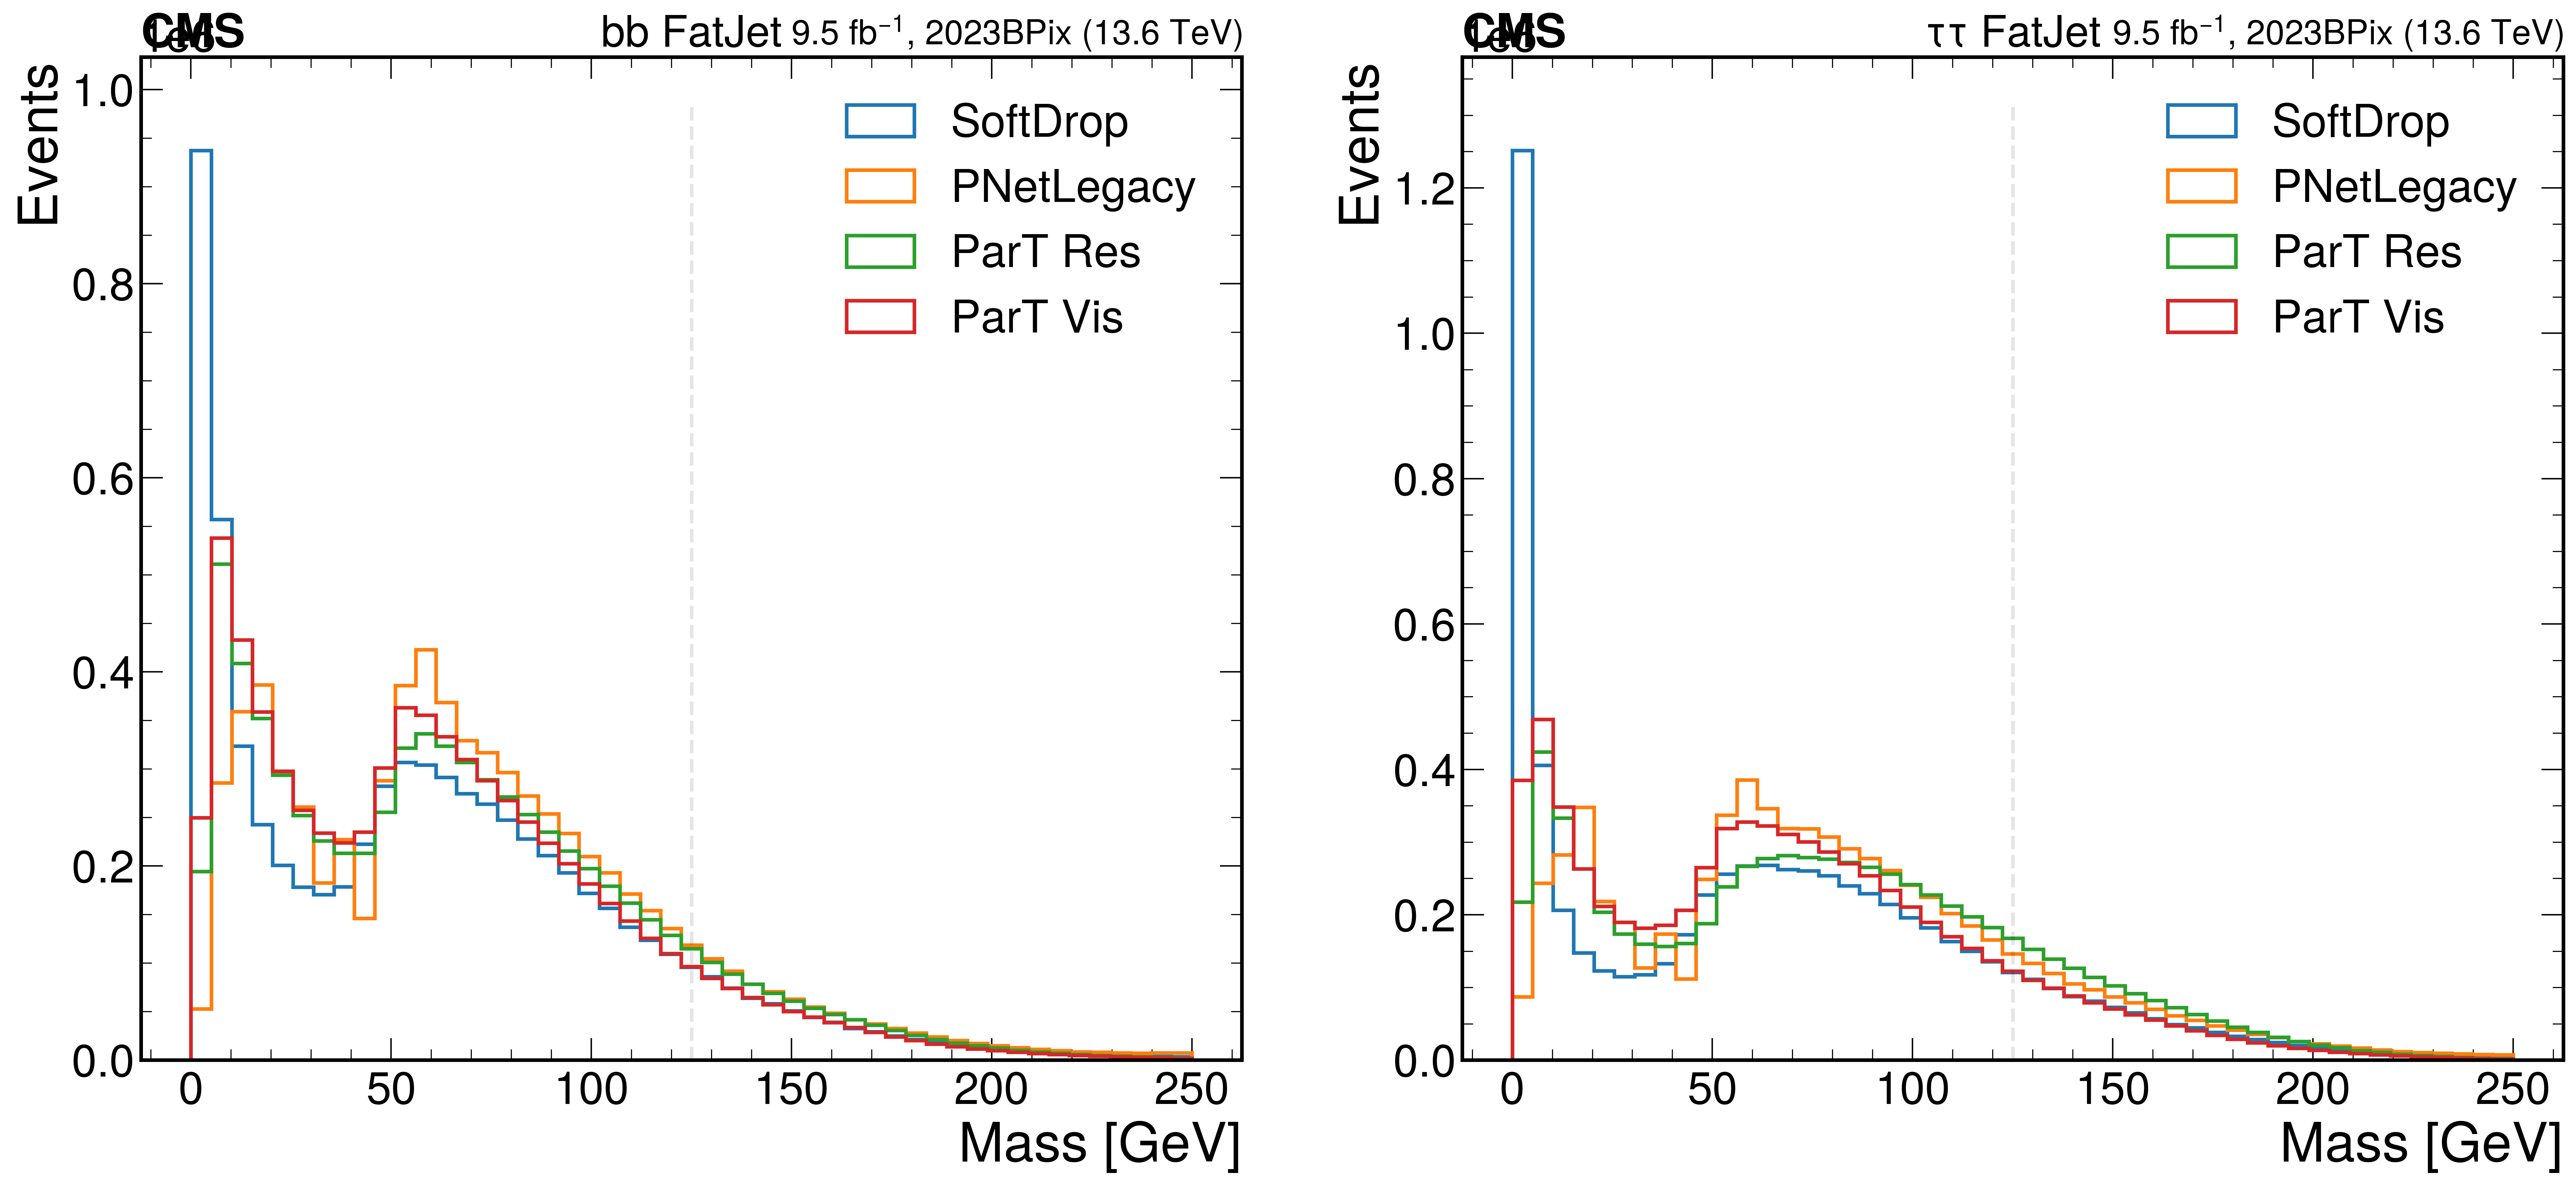

In [ ]:
for year in years:
    for key, label in zip(["hhbbtt", "data"], ["HHbbtt", "Data"]):
        if key == "hhbbtt":
            events = events_dict[year][SIG_KEY]
        else:
            events = pd.concat([events_dict[year][dkey] for dkey in DATA_KEYS])

        bins = np.linspace(0, 250, 50)

        fig, axs = plt.subplots(1, 2, figsize=(24, 10))

        for i, (jet, jlabel) in enumerate(
            zip(["bb", "tautau"], ["bb FatJet", r"$\tau\tau$ FatJet"])
        ):
            ax = axs[i]
            if key == "hhbbtt":
                mask = taggers_dict[year][SIG_KEY][f"{jet}_mask"]
            else:
                mask = np.concatenate(
                    [taggers_dict[year][dkey][f"{jet}_mask"] for dkey in DATA_KEYS], axis=0
                )

            for j, (mkey, mlabel) in enumerate(
                zip(
                    [
                        "ak8FatJetMsd",
                        "ak8FatJetPNetmassLegacy",
                        "ak8FatJetParTmassResApplied",
                        "ak8FatJetParTmassVisApplied",
                    ],
                    ["SoftDrop", "PNetLegacy", "ParT Res", "ParT Vis"],
                )
            ):
                ax.hist(
                    get_jet_vals(events[mkey], mask),
                    bins=bins,
                    histtype="step",
                    weights=events["finalWeight"],
                    label=mlabel,
                    linewidth=2,
                    color=plt.cm.tab10.colors[j],
                )

            ax.vlines(125, 0, ax.get_ylim()[1], linestyle="--", color="k", alpha=0.1)
            ax.set_title(jlabel, fontsize=24)
            ax.set_xlabel("Mass [GeV]")
            # rax.set_xlabel("Mass [GeV]")
            ax.set_ylabel("Events")
            ax.legend()
            ax.set_ylim(0)
            hep.cms.label(
                ax=ax,
                data=key == "data",
                year=year,
                com="13.6",
                fontsize=20,
                lumi=f"{hh_vars.LUMI[year] / 1000:.1f}",
            )

        plt.savefig(plot_dir / f"{key}_{year}_mass.pdf", bbox_inches="tight")
        plt.show()

## Cut-and-count

In [ ]:
# bbeff, tteff = 0.44,0.36 #0.44, 0.36 values determined by highest sig for 1 bkg event
mbb1, mbb2 = 110.0, 160.0
mbbw2 = (mbb2 - mbb1) / 2
mtt1, mtt2 = 50, 1500

# mbbk = "PNetmassLegacy"
mbbk = "ParTmassResApplied"
# mttk = "PNetmassLegacy"
mttk = "ParTmassResApplied"


def compute_sig_bg(year, txbbcut, txttcut, mbb1, mbb2, mbbw2, mtt1, mtt2):
    bg_yield = 0
    sig_yield = 0

    for key in [SIG_KEY] + DATA_KEYS:
        txbbs = get_jet_vals(
            taggers_dict[year][key]["XbbvsQCD"], taggers_dict[year][key]["bb_mask"]
        )
        txtts = get_jet_vals(
            taggers_dict[year][key][f"{taukey}vsQCDTop"], taggers_dict[year][key]["tautau_mask"]
        )
        masstt = get_jet_vals(
            events_dict[year][key][f"ak8FatJet{mttk}"], taggers_dict[year][key]["tautau_mask"]
        )
        massbb = get_jet_vals(
            events_dict[year][key][f"ak8FatJet{mbbk}"], taggers_dict[year][key]["bb_mask"]
        )
        ptbb = get_jet_vals(
            events_dict[year][key]["ak8FatJetPt"], taggers_dict[year][key]["bb_mask"]
        )
        # plt.hist(massbb, np.linspace(0, 200, 100), histtype="step", label=key, weights=events_dict[key]["finalWeight"])

        if key == SIG_KEY:
            cut = (
                (txbbs > txbbcut)
                & (txtts > txttcut)
                & (masstt > mtt1)
                & (masstt < mtt2)
                & (massbb > mbb1)
                & (massbb < mbb2)
                & (ptbb > 250)
            )
            sig_yield = np.sum(events_dict[year][key]["finalWeight"][cut])
        else:
            cut = (
                (txbbs > txbbcut)
                & (txtts > txttcut)
                & (masstt > mtt1)
                & (masstt < mtt2)
                & (ptbb > 250)
            )
            msb1 = (massbb > (mbb1 - mbbw2)) & (massbb < mbb1)
            msb2 = (massbb > mbb2) & (massbb < (mbb2 + mbbw2))
            bg_yield += np.sum(events_dict[year][key]["finalWeight"][cut & msb1])
            bg_yield += np.sum(events_dict[year][key]["finalWeight"][cut & msb2])
    return sig_yield, bg_yield


def determine_cuts(year, gridsize=6, plot=False):
    bbeff_vals = np.linspace(0.3, 0.7, gridsize)
    tteff_vals = np.linspace(0.3, 0.7, gridsize)

    BBeff, TTeff = np.meshgrid(bbeff_vals, tteff_vals)

    sig_bg = lambda bbeff, tteff: compute_sig_bg(
        year=year,
        txbbcut=rocs[year]["bb"]["XbbvsQCD"]["thresholds"][
            plotting._find_nearest(rocs[years[0]]["bb"]["XbbvsQCD"]["tpr"], bbeff)
        ],
        txttcut=rocs[year]["tautau"][f"{taukey}vsQCDTop"]["thresholds"][
            plotting._find_nearest(rocs[years[0]]["tautau"][f"{taukey}vsQCDTop"]["tpr"], tteff)
        ],
        mbb1=mbb1,
        mbb2=mbb2,
        mbbw2=mbbw2,
        mtt1=mtt1,
        mtt2=mtt2,
    )

    sigs, bgs = sig_bg(BBeff, TTeff)
    sel = bgs == 1
    max_sig_idx = np.unravel_index(np.argmax(sigs[sel]), sigs.shape)
    bbeff_opt, tteff_opt = BBeff[max_sig_idx], TTeff[max_sig_idx]

    if plot:
        fig, ax = plt.subplots()
        c = ax.contourf(BBeff, TTeff, sigs, levels=50, cmap="viridis")
        ax.scatter(bbeff_opt, tteff_opt, color="r", label="Optimal cut")
        ax.set_xlabel("Xbb vs QCD cut")
        ax.set_ylabel("Xtauhtauh vs QCD cut")
        ax.set_title(f"Optimal cuts for {year}")
        plt.colorbar(c)
        plt.legend()
        plt.show()
        hep.cms.label(
            ax=ax,
            data=key == "data",
            year=year,
            com="13.6",
            fontsize=20,
            lumi=f"{hh_vars.LUMI[year] / 1000:.1f}",
        )

    return bbeff_opt, tteff_opt


def print_nicely(sig_yield, bg_yield, years):
    print(
        f"""
        
        Yield study year(s) {years}:
        
        """
    )

    print("Sig yield", sig_yield)
    print("BG yield", bg_yield)
    print("limit", 2 * np.sqrt(bg_yield) / sig_yield)

    if "2023" not in years or "2023BPix" not in years:
        print(
            "limit scaled to 22-23 all channels",
            2
            * np.sqrt(bg_yield)
            / sig_yield
            / np.sqrt(
                hh_vars.LUMI["2022-2023"] / np.sum([hh_vars.LUMI[year] for year in years]) * 3
            ),
        )
    print(
        "limit scaled to 22-24 all channels",
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt(
            (124000 + hh_vars.LUMI["2022-2023"])
            / np.sum([hh_vars.LUMI[year] for year in years])
            * 3
        ),
    )
    print(
        "limit scaled to Run 3 all channels",
        2 * np.sqrt(bg_yield) / sig_yield / np.sqrt((360000) / hh_vars.LUMI[year] * 3),
    )
    return


def as_df(sig_yield, bg_yield, years):
    limits = {}

    limits["Sig_Yield"] = sig_yield
    limits["BG_Yield"] = bg_yield
    limits["Limit"] = 2 * np.sqrt(bg_yield) / sig_yield

    if "2023" not in years and "2023BPix" not in years:
        limits["Limit_scaled_22_23"] = (
            2
            * np.sqrt(bg_yield)
            / sig_yield
            / np.sqrt(
                hh_vars.LUMI["2022-2023"] / np.sum([hh_vars.LUMI[year] for year in years]) * 3
            )
        )
    else:
        limits["Limit_scaled_22_23"] = np.nan

    limits["Limit_scaled_22_24"] = (
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt(
            (124000 + hh_vars.LUMI["2022-2023"])
            / np.sum([hh_vars.LUMI[year] for year in years])
            * 3
        )
    )

    limits["Limit_scaled_Run3"] = (
        2
        * np.sqrt(bg_yield)
        / sig_yield
        / np.sqrt((360000) / np.sum([hh_vars.LUMI[year] for year in years]) * 3)
    )

    df = pd.DataFrame([limits])

    return df

NameError: name 'rocs' is not defined

In [ ]:
txbbcut = {}
txttcut = {}

for year in years:
    bbeff, tteff = determine_cuts(year, gridsize=6, plot=True)
    txbbcut[year] = rocs[year]["bb"]["XbbvsQCD"]["thresholds"][
        plotting._find_nearest(rocs[year]["bb"]["XbbvsQCD"]["tpr"], bbeff)
    ]
    txttcut[year] = rocs[year]["tautau"][f"{taukey}vsQCDTop"]["thresholds"][
        plotting._find_nearest(rocs[year]["tautau"][f"{taukey}vsQCDTop"]["tpr"], tteff)
    ]
    print(f"TXbb cut, TXtt cut in {year}:", txbbcut[year], txttcut[year])

In [ ]:
bg_combined = 0
sig_combined = 0

results = {}

for year in years:
    sig_yield, bg_yield = compute_sig_bg(
        year, txbbcut[year], txttcut[year], mbb1, mbb2, mbbw2, mtt1, mtt2
    )
    # print_nicely(sig_yield, bg_yield, [year])
    results[year] = as_df(sig_yield, bg_yield, [year])
    bg_combined += bg_yield
    sig_combined += sig_yield

results["Combined"] = as_df(sig_combined, bg_combined, years)

In [ ]:
results_df = pd.concat(results, axis=0)
results_df.index = results_df.index.droplevel(1)
print(results_df.T.to_markdown())

| Muons                   |        2023 |    2023BPix |    Combined |
|:-------------------|------------:|------------:|------------:|
| Sig_Yield          |   0.0305736 |   0.0150834 |   0.0456569 |
| BG_Yield           |   1         |   0         |   1         |
| Limit              |  65.416     |   0         |  43.805     |
| Limit_scaled_22_23 | nan         | nan         | nan         |
| Limit_scaled_22_24 |  11.6528    |   0         |   9.66919   |
| Limit_scaled_Run3  |   8.36266   |   0         |   6.93912   |

| **Period (Electrons)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|----------:|----------:|---------------------------:|
| **Sig yield**                       | 0.015     | 0.046     | 0.061                     |
| **BG yield**                        | 2.000     | 7.000     | 9.000                     |
| **limit**                           | 190.635   | 115.250   | 98.765                    |
| **limit scaled to 22-23 channels**  | 39.654    | 43.576    | 42.621                    |
| **limit scaled to 22-24 channels**  | 22.821    | 25.078    | 24.529                    |
| **limit scaled to Run 3 channels**  | 16.378    | 17.997    | 17.603                    |


| **Period (Muons)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|---------:|----------:|---------------------------:|
| **Sig yield**                       | 0.015    | 0.047     | 0.062                     |
| **BG yield**                        | 0.000    | 3.000     | 3.000                     |
| **limit**                           | 0.000    | 73.528    | 55.506                    |
| **limit scaled to 22-23 channels**  | 0.000    | 27.801    | 23.953                    |
| **limit scaled to 22-24 channels**  | 0.000    | 16.000    | 13.785                    |
| **limit scaled to Run 3 channels**  | 0.000    | 11.482    | 9.893                     |


| **Period (Full hadronic)**                        | **2022**  | **2022EE** | **Combined (2022, 2022EE)** |
|-------------------------------------|---------:|----------:|---------------------------:|
| **Sig yield**                       | 0.032    | 0.104     | 0.136                     |
| **BG yield**                        | 1.000    | 3.000     | 4.000                     |
| **limit**                           | 62.243   | 33.457    | 29.483                    |
| **limit scaled to 22-23 channels**  | 12.947   | 12.650    | 12.723                    |
| **limit scaled to 22-24 channels**  | 7.451    | 7.280     | 7.322                     |
| **limit scaled to Run 3 channels**  | 5.347    | 5.225     | 5.255                     |
